## Initialisation

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt

Récupération des données et ajout de la colonne "Taux MARGE BRUTE"

In [2]:
col = pd.read_excel('Fiches/col_df_final.xlsx')
df = pd.read_excel('Fiches/clean_df.xlsx')

tmp = pd.DataFrame()
tmp["Taux MARGE BRUTE"] = 100 * df["MARGE BRUTE"]/df["TOTAL CA + Prod Centralisées"]
df = pd.concat([df, tmp], axis=1)
df = df[(df["Taux MARGE BRUTE"] < 100) & (df["Taux MARGE BRUTE"] > -100)]
print(df.shape)

(3144, 392)


Création d'un dataset contenant uniquement une ligne par année et par agence et tri des meilleurs et pires agences

In [3]:
'''
Création d'un dataset contenant uniquement une ligne par année et par agence
'''

df_year = df[(df['Date'] > 100) & (df['Type'] =="REEL")]
df_year["Date"] = df_year["Date"].astype(int)

# Supprimer les doublons de date pour chaque agence
df_year = df_year.drop_duplicates(subset=["Filtre Agence", "Date"])
df_year["Date"] = pd.to_datetime(df_year["Date"], format='%Y')
print(df_year)

     Filtre Agence   REGION ACTIVITE            AGENCE  \
0       6A-PCLROYS    SOATL      BTB  La Roche Sur Yon   
1       6A-PCLROYS    SOATL      BTB  La Roche Sur Yon   
17      6A-PCLROYS    SOATL      BTB  La Roche Sur Yon   
18      6A-PCLROYS    SOATL      BTB  La Roche Sur Yon   
19      6A-PCLROYS    SOATL      BTB  La Roche Sur Yon   
...            ...      ...      ...               ...   
3205    6A-XPCCHLT    SOATL      BTC          Challans   
3221    6A-XPCCHLT    SOATL      BTC          Challans   
3222   4A-AURBGRNT  Sud Est      BTC          Grenoble   
3223   4A-AURBGRNT  Sud Est      BTC          Grenoble   
3239   4A-AURBGRNT  Sud Est      BTC          Grenoble   

                                              name_file            name_sheet  \
0     Data/Fiches\V2-Reporting_SOATL 12_2020_Poitou ...  LA ROCHE SUR YON BTB   
1     Data/Fiches\V2-Reporting_SOATL 12_2020_Poitou ...  LA ROCHE SUR YON BTB   
17    Data/Fiches\V2-Reporting_SOATL 12_2020_Poitou ...  LA 

C:\Users\mrant\AppData\Local\Temp\ipykernel_352\2543175352.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year["Date"] = df_year["Date"].astype(int)


In [4]:
df_year.to_excel("Fiches/df_year.xlsx", index=False)

In [5]:
best_agence = df_year[df_year["Date"]=="2023-01-01"].groupby("Filtre Agence")["Taux MARGE BRUTE"].mean().sort_values(ascending=False).head(15)
worst_agence = df_year[df_year["Date"]=="2023-01-01"].groupby("Filtre Agence")["Taux MARGE BRUTE"].mean().sort_values(ascending=True).head(15)

best_agence_BTC = df_year[(df_year["Date"]=="2023-01-01") & (df_year["ACTIVITE"]=="BTC")].groupby("Filtre Agence")["Taux MARGE BRUTE"].mean().sort_values(ascending=False).head(15)
worst_agence_BTC = df_year[(df_year["Date"]=="2023-01-01") & (df_year["ACTIVITE"]=="BTC")].groupby("Filtre Agence")["Taux MARGE BRUTE"].mean().sort_values(ascending=True).head(15)
best_agence_BTB = df_year[(df_year["Date"]=="2023-01-01") & (df_year["ACTIVITE"]=="BTB")].groupby("Filtre Agence")["Taux MARGE BRUTE"].mean().sort_values(ascending=False).head(15)
worst_agence_BTB = df_year[(df_year["Date"]=="2023-01-01") & (df_year["ACTIVITE"]=="BTB")].groupby("Filtre Agence")["Taux MARGE BRUTE"].mean().sort_values(ascending=True).head(15)

Colonnes conseillées pour l'analyse

In [6]:
cols = ["CA Contrats Collectif","ETP EFFECTIF Exploitation (Présence)","Nbre de véhicules Exploitation",
        "TOTAL AUTRES COUTS_1","TOTAL FRAIS GENERAUX_1","ETP Chef Agence","ETP Responsable Exploitation","ETP Secrétaire/Assitant(e) Agence",
        "ETP EFFECTIF Agence (Présence)","TOTAL VEHICULES_2","TOTAL AUTRES COUTS_2","TOTAL FRAIS GENERAUX_2",
        "Nombre de Tech. moyen par Chef Equipe","Nombre de Tech. moyen par Magasinier","Nombre de Techniciens par Secrétaire"]

## Création de models

### OAUSI C'EST ALEX LE BOSS

In [7]:
ranked_agence_BTB = df_year[(df_year["Filtre Agence"].isin(best_agence.index)) & (df_year["Date"]=="2023-01-01") & (df_year["ACTIVITE"]=="BTB")].sort_values(by="Taux MARGE BRUTE", ascending=True)
ranked_agence_BTC = df_year[(df_year["Filtre Agence"].isin(best_agence.index)) & (df_year["Date"]=="2023-01-01") & (df_year["ACTIVITE"]=="BTC")].sort_values(by="Taux MARGE BRUTE", ascending=True)

In [8]:
ranked_agence_BTC['classement'] = ranked_agence_BTC['Taux MARGE BRUTE'].rank(ascending=False, method='min')
ranked_agence_BTC

ranked_agence_BTB['classement'] = ranked_agence_BTB['Taux MARGE BRUTE'].rank(ascending=False, method='min')
ranked_agence_BTB

,Filtre Agence,REGION,ACTIVITE,AGENCE,name_file,name_sheet,Date,Type,CA Chauffage,CA Robinetterie (Hors GEG),...,Amort,2023.1,AC = 092901,Crédit bail,Amortissement OP,Amortissement Agence,Amortissement Structure Commerciale,Amortissement Structure DR,Taux MARGE BRUTE,classement
359,6A-BORAGLS,SOATL,BTB,Anglet,Data/Fiches\Reporting_SOATL 12_2023_Aquitaine....,ANGLET BTB,2023-01-01,REEL,2182.219,316.418,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.608091,7.0
269,4A-AURBVLFR,Sud Est,BTB,Villefranche,Data/Fiches\Fiches suiveuses_2023_12 - Région ...,VILLEFRANCHE,2023-01-01,REEL,228.128,310.591,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.469733,6.0
107,2A-RPU-BONS,IDF-NDI,BTB,Bonneuil,Data/Fiches\5 - Fiches Suiveuses_2023_11_IDF_S...,BONNEUIL,2023-01-01,REEL,4.252,1719.962,...,-7.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.167283,5.0
179,6A-BORAGEN,SOATL,BTB,Agen,Data/Fiches\Reporting_SOATL 12_2023_Aquitaine....,AGEN,2023-01-01,REEL,447.095,152.758,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.531501,4.0
71,6A-GPLNEXP,SOATL,BTB,Nantes Gpl Exploitation,Data/Fiches\Reporting_SOATL 12_2023_Poitou Cha...,NANTES GPL EXP BTB,2023-01-01,REEL,0.000,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.667346,3.0
143,3A-NANC,Nord Est,BTB,Nancy,Data/Fiches\Copie Valeur Fiches Suiveuses_2023...,NANC,2023-01-01,REEL,376.102,258.096,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.259781,2.0
35,6A-PCLROYS,SOATL,BTB,La Roche Sur Yon,Data/Fiches\Reporting_SOATL 12_2023_Poitou Cha...,LA ROCHE SUR YON BTB,2023-01-01,REEL,135.183,241.836,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.628252,1.0


In [9]:
df.loc[(df["Filtre Agence"] == "6A-TOUMTPS") & (df["Date"] == 2018.12) ]["CA par Techniciens (dont Intérim & S-T)"]

864    128.935514
Name: CA par Techniciens (dont Intérim & S-T), dtype: float64

In [10]:
best_agence_BTC
best_agence_BTB

worst_agence_BTC
worst_agence_BTB

best_agence_btb = df[(df["Filtre Agence"].isin(best_agence_BTB.index)) & (df["Date"] == 2023.12)]
ranked_agence = df_year[df_year["Date"]=="2023-01-01"].groupby("Filtre Agence")["Taux MARGE BRUTE"].mean().sort_values(ascending=True)


In [11]:
ca_tech_best_btc = df[df["Filtre Agence"].isin(best_agence_BTC.index)]["CA par Techniciens (dont Intérim & S-T)"].mean()
ca_tech_best_btb = df[df["Filtre Agence"].isin(best_agence_BTB.index)]["CA par Techniciens (dont Intérim & S-T)"].mean()
ca_tech_worst_btc = df[df["Filtre Agence"].isin(worst_agence_BTC.index)]["CA par Techniciens (dont Intérim & S-T)"].mean()
ca_tech_worst_btb = df[df["Filtre Agence"].isin(worst_agence_BTB.index)]["CA par Techniciens (dont Intérim & S-T)"].mean()

ca_tech_best_btc, ca_tech_best_btb, ca_tech_worst_btc, ca_tech_worst_btb

(67.33744757204444, 56.21106610206706, 71.28710186701058, 63.172552048195456)

## Graphs

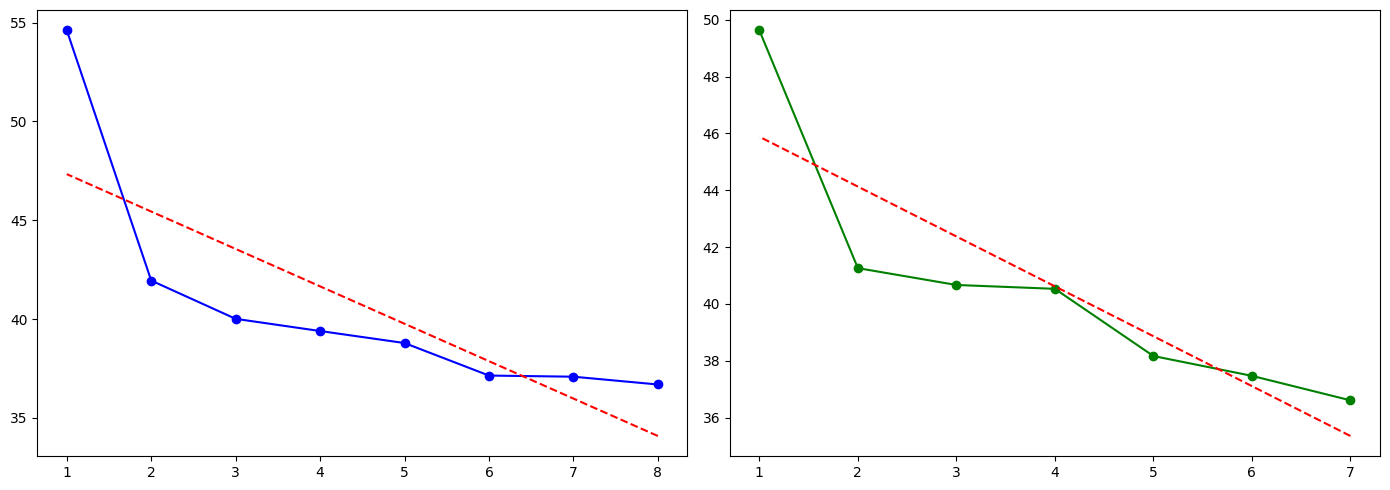

In [12]:
# Taux MARGE BRUTE

fig, ax = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

axe_x = 'classement'
axe_y = 'Taux MARGE BRUTE'

ax[0].plot(ranked_agence_BTC[axe_x], ranked_agence_BTC[axe_y], marker='o', color='blue')
z_btc = np.polyfit(ranked_agence_BTC[axe_x], ranked_agence_BTC[axe_y], 1) # Fit and plot a trend line for BTC
p_btc = np.poly1d(z_btc)
ax[0].plot(ranked_agence_BTC[axe_x], p_btc(ranked_agence_BTC[axe_x]), "r--")

ax[1].plot(ranked_agence_BTB[axe_x], ranked_agence_BTB[axe_y], marker='o', color='green')
z_btb = np.polyfit(ranked_agence_BTB[axe_x], ranked_agence_BTB[axe_y], 1) # Fit and plot a trend line for BTB
p_btb = np.poly1d(z_btb)
ax[1].plot(ranked_agence_BTB[axe_x], p_btb(ranked_agence_BTB[axe_x]), "r--")

# Show the plot
plt.tight_layout()
plt.show()

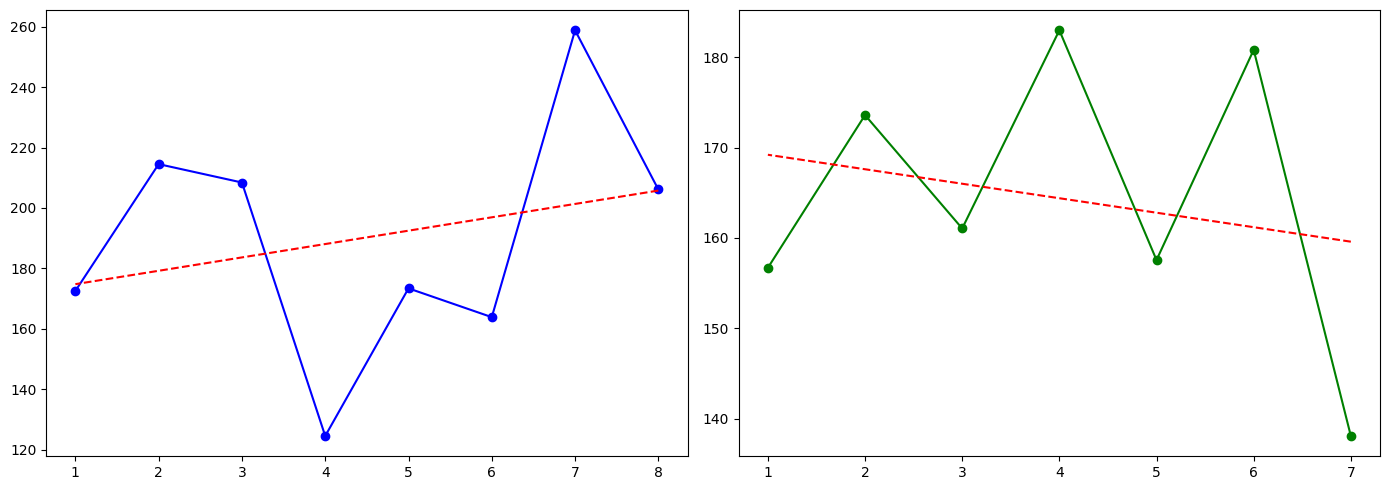

In [13]:
# CA par Techniciens (dont Intérim & S-T)

import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

axe_x = 'classement'
axe_y = 'CA par Techniciens (dont Intérim & S-T)'

ax[0].plot(ranked_agence_BTC[axe_x], ranked_agence_BTC[axe_y], marker='o', color='blue')
z_btc = np.polyfit(ranked_agence_BTC[axe_x], ranked_agence_BTC[axe_y], 1) # Fit and plot a trend line for BTC
p_btc = np.poly1d(z_btc)
ax[0].plot(ranked_agence_BTC[axe_x], p_btc(ranked_agence_BTC[axe_x]), "r--")

ax[1].plot(ranked_agence_BTB[axe_x], ranked_agence_BTB[axe_y], marker='o', color='green')
z_btb = np.polyfit(ranked_agence_BTB[axe_x], ranked_agence_BTB[axe_y], 1) # Fit and plot a trend line for BTB
p_btb = np.poly1d(z_btb)
ax[1].plot(ranked_agence_BTB[axe_x], p_btb(ranked_agence_BTB[axe_x]), "r--")

# Show the plot
plt.tight_layout()
plt.show()


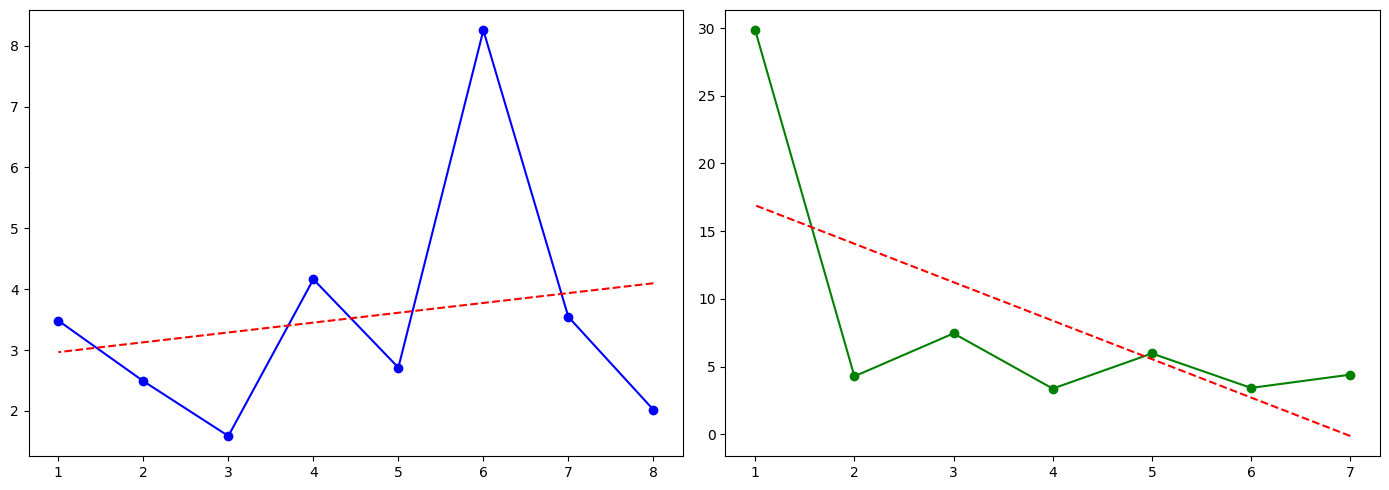

In [14]:
# Nombre de Techniciens par Secrétaire

fig, ax = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

axe_x = 'classement'
axe_y = 'Nombre de Techniciens par Secrétaire'

ax[0].plot(ranked_agence_BTC[axe_x], ranked_agence_BTC[axe_y], marker='o', color='blue')
z_btc = np.polyfit(ranked_agence_BTC[axe_x], ranked_agence_BTC[axe_y], 1) # Fit and plot a trend line for BTC
p_btc = np.poly1d(z_btc)
ax[0].plot(ranked_agence_BTC[axe_x], p_btc(ranked_agence_BTC[axe_x]), "r--")

ax[1].plot(ranked_agence_BTB[axe_x], ranked_agence_BTB[axe_y], marker='o', color='green')
z_btb = np.polyfit(ranked_agence_BTB[axe_x], ranked_agence_BTB[axe_y], 1) # Fit and plot a trend line for BTB
p_btb = np.poly1d(z_btb)
ax[1].plot(ranked_agence_BTB[axe_x], p_btb(ranked_agence_BTB[axe_x]), "r--")

# Show the plot
plt.tight_layout()
plt.show()


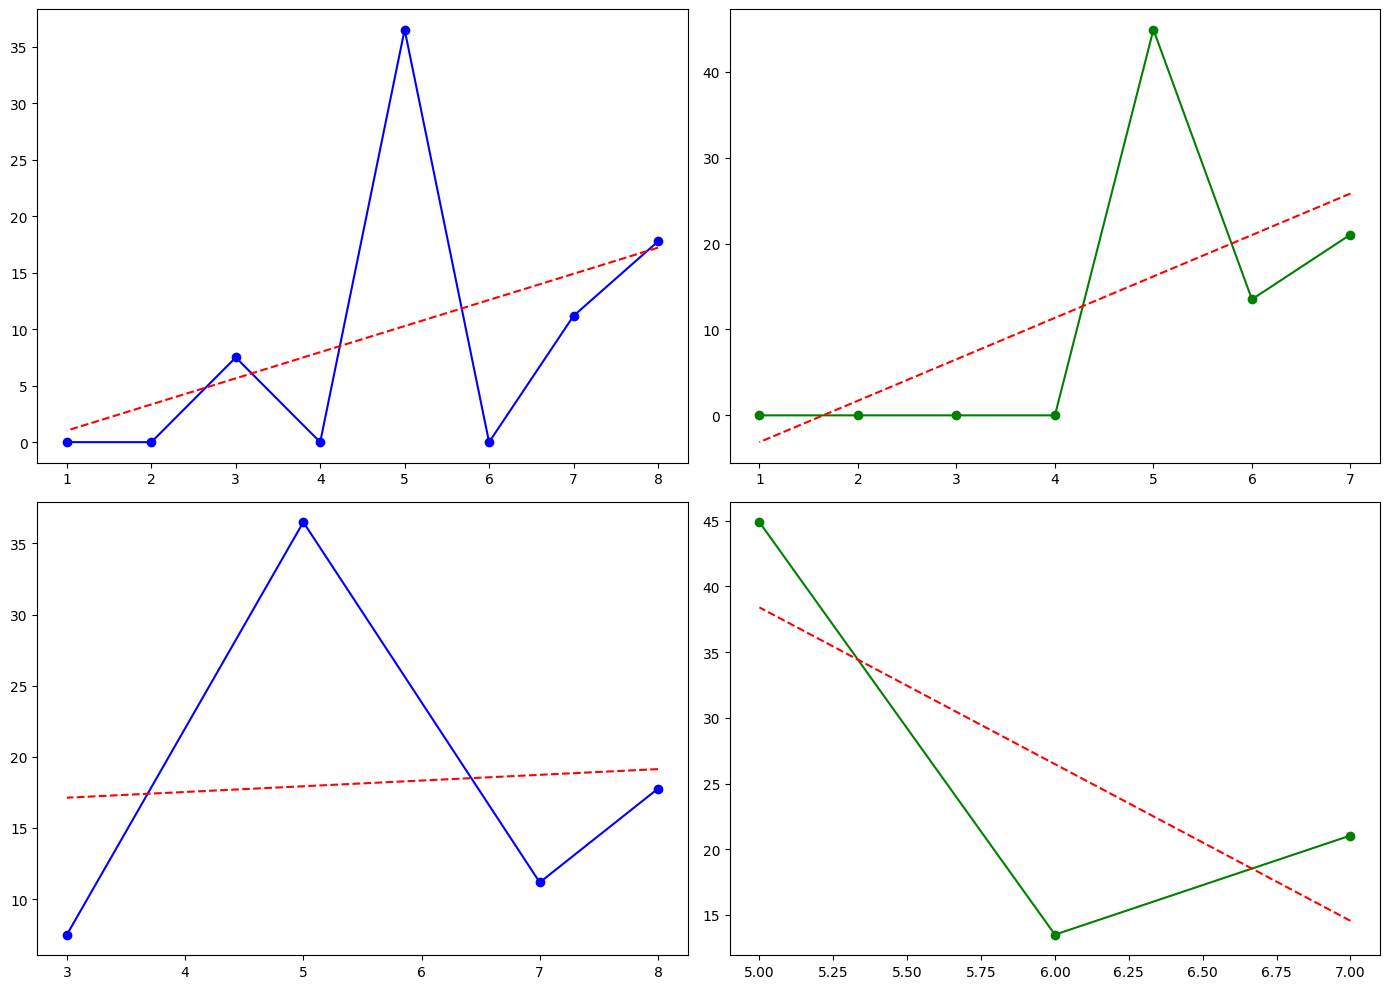

In [15]:
# Nombre de Tech. moyen par Magasinier

fig, ax = plt.subplots(2, 2, figsize=(14, 10))  # Correct the figsize for better spacing

axe_x = 'classement'
axe_y = 'Nombre de Tech. moyen par Magasinier'

# Use the correct indexing for subplots
ax[0, 0].plot(ranked_agence_BTC[axe_x], ranked_agence_BTC[axe_y], marker='o', color='blue')
z_btc = np.polyfit(ranked_agence_BTC[axe_x], ranked_agence_BTC[axe_y], 1) # Fit and plot a trend line for BTC
p_btc = np.poly1d(z_btc)
ax[0, 0].plot(ranked_agence_BTC[axe_x], p_btc(ranked_agence_BTC[axe_x]), "r--")

ax[0, 1].plot(ranked_agence_BTB[axe_x], ranked_agence_BTB[axe_y], marker='o', color='green')
z_btb = np.polyfit(ranked_agence_BTB[axe_x], ranked_agence_BTB[axe_y], 1) # Fit and plot a trend line for BTB
p_btb = np.poly1d(z_btb)
ax[0, 1].plot(ranked_agence_BTB[axe_x], p_btb(ranked_agence_BTB[axe_x]), "r--")

# Filter and plot data excluding zeros for BTC in subplot [1, 0]
btc_filtered = ranked_agence_BTC[ranked_agence_BTC[axe_y] != 0]
ax[1, 0].plot(btc_filtered[axe_x], btc_filtered[axe_y], marker='o', color='blue')
z_btc = np.polyfit(btc_filtered[axe_x], btc_filtered[axe_y], 1) # Fit and plot a trend line
p_btc = np.poly1d(z_btc)
ax[1, 0].plot(btc_filtered[axe_x], p_btc(btc_filtered[axe_x]), "r--")

# Filter and plot data excluding zeros for BTB in subplot [1, 1]
btb_filtered = ranked_agence_BTB[ranked_agence_BTB[axe_y] != 0]
ax[1, 1].plot(btb_filtered[axe_x], btb_filtered[axe_y], marker='o', color='green')
z_btb = np.polyfit(btb_filtered[axe_x], btb_filtered[axe_y], 1) # Fit and plot a trend line
p_btb = np.poly1d(z_btb)
ax[1, 1].plot(btb_filtered[axe_x], p_btb(btb_filtered[axe_x]), "r--")

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()


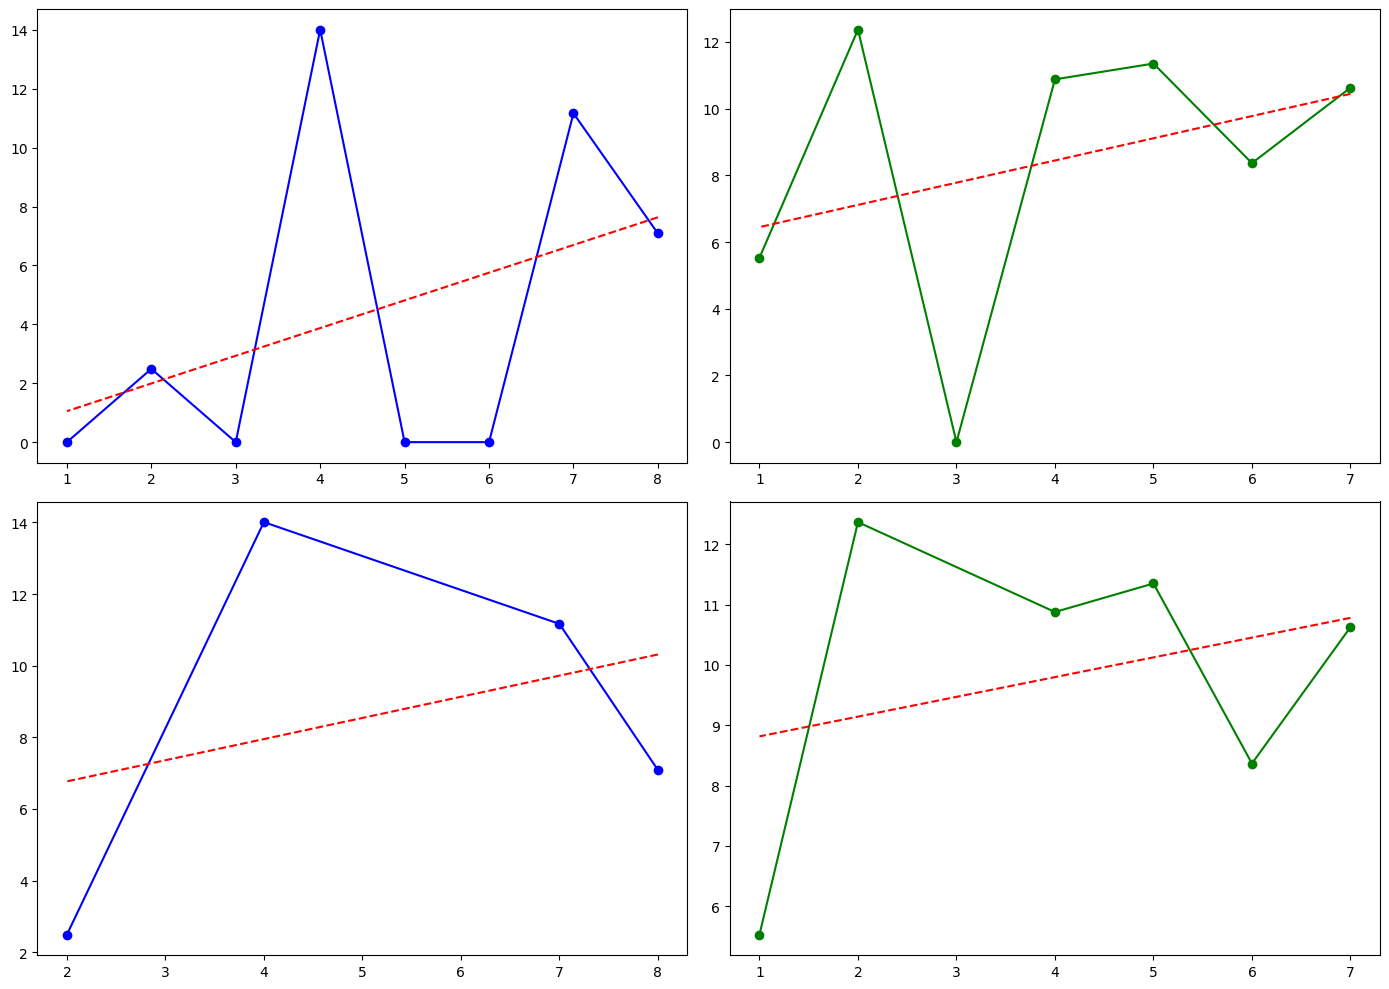

In [16]:
# Nombre de Tech. moyen par Chef Equipe

fig, ax = plt.subplots(2, 2, figsize=(14, 10))

axe_x = 'classement'
axe_y = 'Nombre de Tech. moyen par Chef Equipe'

# Use the correct indexing for subplots
ax[0, 0].plot(ranked_agence_BTC[axe_x], ranked_agence_BTC[axe_y], marker='o', color='blue')
z_btc = np.polyfit(ranked_agence_BTC[axe_x], ranked_agence_BTC[axe_y], 1) # Fit and plot a trend line for BTC
p_btc = np.poly1d(z_btc)
ax[0, 0].plot(ranked_agence_BTC[axe_x], p_btc(ranked_agence_BTC[axe_x]), "r--")

ax[0, 1].plot(ranked_agence_BTB[axe_x], ranked_agence_BTB[axe_y], marker='o', color='green')
z_btb = np.polyfit(ranked_agence_BTB[axe_x], ranked_agence_BTB[axe_y], 1) # Fit and plot a trend line for BTB
p_btb = np.poly1d(z_btb)
ax[0, 1].plot(ranked_agence_BTB[axe_x], p_btb(ranked_agence_BTB[axe_x]), "r--")

# Filter and plot data excluding zeros for BTC in subplot [1, 0]
btc_filtered = ranked_agence_BTC[ranked_agence_BTC[axe_y] != 0]
ax[1, 0].plot(btc_filtered[axe_x], btc_filtered[axe_y], marker='o', color='blue')
z_btc = np.polyfit(btc_filtered[axe_x], btc_filtered[axe_y], 1) # Fit and plot a trend line
p_btc = np.poly1d(z_btc)
ax[1, 0].plot(btc_filtered[axe_x], p_btc(btc_filtered[axe_x]), "r--")

# Filter and plot data excluding zeros for BTB in subplot [1, 1]
btb_filtered = ranked_agence_BTB[ranked_agence_BTB[axe_y] != 0]
ax[1, 1].plot(btb_filtered[axe_x], btb_filtered[axe_y], marker='o', color='green')
z_btb = np.polyfit(btb_filtered[axe_x], btb_filtered[axe_y], 1) # Fit and plot a trend line
p_btb = np.poly1d(z_btb)
ax[1, 1].plot(btb_filtered[axe_x], p_btb(btb_filtered[axe_x]), "r--")

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

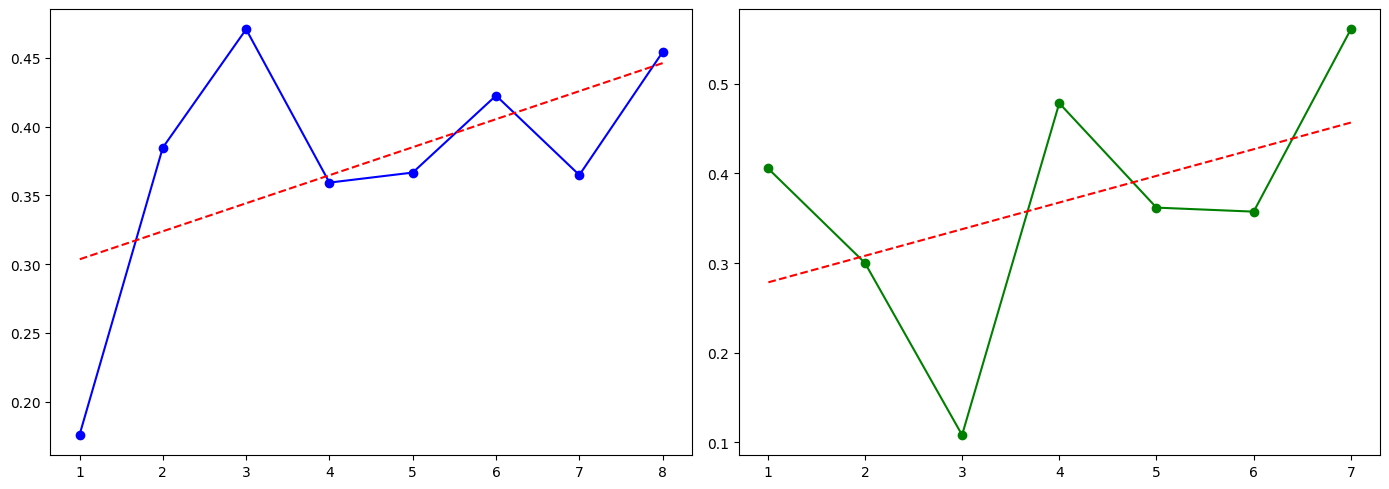

In [17]:
#  Fournitures Travaux & Ventes / (CA Travaux+Prod.Centralisées)   (en %)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

axe_x = 'classement'
axe_y = '% / (CA Travaux+Prod.Centralisées)'

ax[0].plot(ranked_agence_BTC[axe_x], ranked_agence_BTC[axe_y], marker='o', color='blue')
z_btc = np.polyfit(ranked_agence_BTC[axe_x], ranked_agence_BTC[axe_y], 1) # Fit and plot a trend line for BTC
p_btc = np.poly1d(z_btc)
ax[0].plot(ranked_agence_BTC[axe_x], p_btc(ranked_agence_BTC[axe_x]), "r--")

ax[1].plot(ranked_agence_BTB[axe_x], ranked_agence_BTB[axe_y], marker='o', color='green')
z_btb = np.polyfit(ranked_agence_BTB[axe_x], ranked_agence_BTB[axe_y], 1) # Fit and plot a trend line for BTB
p_btb = np.poly1d(z_btb)
ax[1].plot(ranked_agence_BTB[axe_x], p_btb(ranked_agence_BTB[axe_x]), "r--")

# Show the plot
plt.tight_layout()
plt.show()


In [18]:
print(df.columns)
if '% Absences Exploitation' in df.columns:
    # Column exists
    print("Column exists!")
else:
    # Column does not exist
    print("Column does not exist.")
print(df.shape)

Index(['Filtre Agence', 'REGION', 'ACTIVITE', 'AGENCE', 'name_file',
       'name_sheet', 'Date', 'Type', 'CA Chauffage',
       'CA Robinetterie (Hors GEG)',
       ...
       '2022.1', 'Amort', '2023.1', 'AC = 092901', 'Crédit bail',
       'Amortissement OP', 'Amortissement Agence',
       'Amortissement Structure Commerciale', 'Amortissement Structure DR',
       'Taux MARGE BRUTE'],
      dtype='object', length=392)
Column does not exist.
(3144, 392)


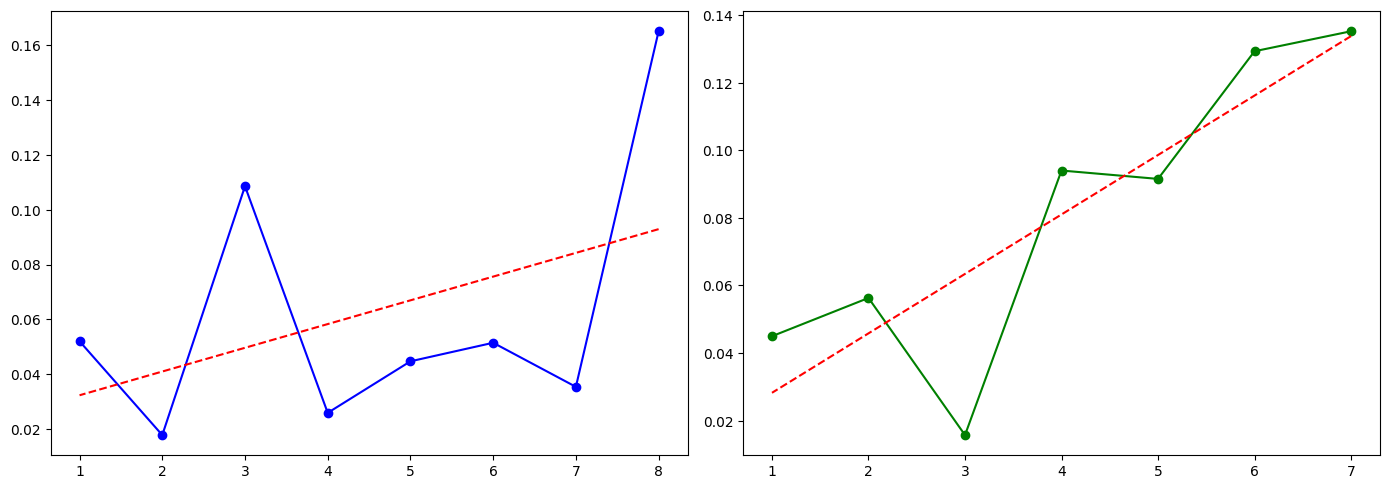

In [19]:
# % Absences_1

fig, ax = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# axe_x = 'Taux MARGE BRUTE'
axe_x = 'classement'
axe_y = '% Absences_1'

ax[0].plot(ranked_agence_BTC[axe_x], ranked_agence_BTC[axe_y], marker='o', color='blue')
z_btc = np.polyfit(ranked_agence_BTC[axe_x], ranked_agence_BTC[axe_y], 1) # Fit and plot a trend line for BTC
p_btc = np.poly1d(z_btc)
ax[0].plot(ranked_agence_BTC[axe_x], p_btc(ranked_agence_BTC[axe_x]), "r--")

ax[1].plot(ranked_agence_BTB[axe_x], ranked_agence_BTB[axe_y], marker='o', color='green')
z_btb = np.polyfit(ranked_agence_BTB[axe_x], ranked_agence_BTB[axe_y], 1) # Fit and plot a trend line for BTB
p_btb = np.poly1d(z_btb)
ax[1].plot(ranked_agence_BTB[axe_x], p_btb(ranked_agence_BTB[axe_x]), "r--")

# Show the plot
plt.tight_layout()
plt.show()


In [20]:
[col for col in ranked_agence_BTC.columns if '%' in str(col)]

['% / (CA Contrats Collectif hors GEG)',
 '% / (CA GEG)',
 '% / (CA Travaux+Prod.Centralisées)',
 '% / (CA+Prod.Centralisées)_1',
 '% Absences_1',
 '% / (CA+Prod.Centralisées)_2',
 '% / (CA+Prod.Centralisées)_3',
 '% / (CA+Prod.Centralisées)_4',
 '% / (CA+Prod.Centralisées)_5',
 '% / (CA+Prod.Centralisées)_6',
 '% / (CA+Prod.Centralisées)_7',
 '% Absences_2',
 '% / (CA+Prod.Centralisées)_8',
 '% / (CA+Prod.Centralisées)_9',
 '% / (CA+Prod.Centralisées)_10',
 '% / (CA+Prod.Centralisées)_11',
 '% / (CA+Prod.Centralisées)_12',
 '% / (CA+Prod.Centralisées)_13',
 '% / (CA+Prod.Centralisées)_14',
 '% / (CA+Prod.Centralisées)_15',
 '% / (CA+Prod.Centralisées)_16',
 '% Échéances / PTF']

In [21]:
ranked_agence_BTC['Filtre Agence'].unique()

array(['6A-XTBRENT', '2A-CHC-REPT', '6A-XTODZAT', '6A-XTOAGLT',
       '6A-XTOPAUT', '6A-XTSPERT', '6A-XTOARCT', '6A-XVLANGT'],
      dtype=object)

In [22]:
# ranked_agence_BTC[ranked_agence_BTC["Filtre Agence"] == "6A-XTSBZPT"]['% / (CA+Prod.Centralisées)_1'] # Total Fourniture
# ranked_agence_BTC[ranked_agence_BTC["Filtre Agence"] == "6A-XTSBZPT"]['% / (CA+Prod.Centralisées)_2'] # Total Salaire
# ranked_agence_BTC[ranked_agence_BTC["Filtre Agence"] == "6A-XTSBZPT"]['% / (CA+Prod.Centralisées)_3'] # Total Vehicules
# ranked_agence_BTC[ranked_agence_BTC["Filtre Agence"] == "6A-XTSBZPT"]['% / (CA+Prod.Centralisées)_4'] # Total Autres cout
# ranked_agence_BTC[ranked_agence_BTC["Filtre Agence"] == "6A-XTSBZPT"]['% / (CA+Prod.Centralisées)_5'] # Total Frais Generaux
# ranked_agence_BTC[ranked_agence_BTC["Filtre Agence"] == "6A-XTSBZPT"]['% / (CA+Prod.Centralisées)_6'] # Depences d'exploitation
# ranked_agence_BTC[ranked_agence_BTC["Filtre Agence"] == "6A-XTSBZPT"]['% / (CA+Prod.Centralisées)_7'] # Marge Brute
# ranked_agence_BTC[ranked_agence_BTC["Filtre Agence"] == "6A-XTSBZPT"]['% / (CA+Prod.Centralisées)_8'] # Total Salaires
# ranked_agence_BTC[ranked_agence_BTC["Filtre Agence"] == "6A-XTSBZPT"]['% / (CA+Prod.Centralisées)_9'] # Total Vehicules
# ranked_agence_BTC[ranked_agence_BTC["Filtre Agence"] == "6A-XTSBZPT"]['% / (CA+Prod.Centralisées)_10'] # Total Autres couts
# ranked_agence_BTC[ranked_agence_BTC["Filtre Agence"] == "6A-XTSBZPT"]['% / (CA+Prod.Centralisées)_11'] # Total Frais Generaux
# ranked_agence_BTC[ranked_agence_BTC["Filtre Agence"] == "6A-XTSBZPT"]['% / (CA+Prod.Centralisées)_12'] # Résultat Exceptionel
# ranked_agence_BTC[ranked_agence_BTC["Filtre Agence"] == "6A-XTSBZPT"]['% / (CA+Prod.Centralisées)_13'] # Dépence Agence
# ranked_agence_BTC[ranked_agence_BTC["Filtre Agence"] == "6A-XTSBZPT"]['% / (CA+Prod.Centralisées)_14'] # Marge Agence
# ranked_agence_BTC[ranked_agence_BTC["Filtre Agence"] == "6A-XTOARCT"]['% / (CA+Prod.Centralisées)_15'] # Dépenses DR
# ranked_agence_BTC[ranked_agence_BTC["Filtre Agence"] == "6A-XTOARCT"]['% / (CA+Prod.Centralisées)_16'] # Marge region

rename_dict = {
    '% / (CA+Prod.Centralisées)_1': '% / (CA+Prod.Centralisées)_Total_Fourniture',
    '% / (CA+Prod.Centralisées)_2': '% / (CA+Prod.Centralisées)_Total_Salaire_Exploitation',
    '% / (CA+Prod.Centralisées)_3': '% / (CA+Prod.Centralisées)_Total_Vehicules_Exploitation',
    '% / (CA+Prod.Centralisées)_4': '% / (CA+Prod.Centralisées)_Total_Autres_couts_Exploitation',
    '% / (CA+Prod.Centralisées)_5': '% / (CA+Prod.Centralisées)_Total_Frais_Generaux_Exploitation',
    '% / (CA+Prod.Centralisées)_6': '% / (CA+Prod.Centralisées)_Depences_exploitation',
    '% / (CA+Prod.Centralisées)_7': '% / (CA+Prod.Centralisées)_Marge_Brute',
    '% / (CA+Prod.Centralisées)_8': '% / (CA+Prod.Centralisées)_Total_Salaire_Agence',
    '% / (CA+Prod.Centralisées)_9': '% / (CA+Prod.Centralisées)_Total_Vehicules_Agence',
    '% / (CA+Prod.Centralisées)_10': '% / (CA+Prod.Centralisées)_Total_Autres_Couts_Agence',
    '% / (CA+Prod.Centralisées)_11': '% / (CA+Prod.Centralisées)_Total_Frais_Generaux_Agence',
    '% / (CA+Prod.Centralisées)_12': '% / (CA+Prod.Centralisées)_Resultat_Exceptionel',
    '% / (CA+Prod.Centralisées)_13': '% / (CA+Prod.Centralisées)_Depence_Agence',
    '% / (CA+Prod.Centralisées)_14': '% / (CA+Prod.Centralisées)_Marge_Agence',
    '% / (CA+Prod.Centralisées)_15': '% / (CA+Prod.Centralisées)_Depenses_DR',
    '% / (CA+Prod.Centralisées)_16': '% / (CA+Prod.Centralisées)_Marge_Region',
    '% Absences_1': '% Absences Exploitation',
    '% Absences_2': '% Absences Agence',
}

ranked_agence_BTC.rename(columns=rename_dict, inplace=True)
ranked_agence_BTB.rename(columns=rename_dict, inplace=True)

In [23]:
[col for col in ranked_agence_BTC.columns if '%' in str(col)]

['% / (CA Contrats Collectif hors GEG)',
 '% / (CA GEG)',
 '% / (CA Travaux+Prod.Centralisées)',
 '% / (CA+Prod.Centralisées)_Total_Fourniture',
 '% Absences Exploitation',
 '% / (CA+Prod.Centralisées)_Total_Salaire_Exploitation',
 '% / (CA+Prod.Centralisées)_Total_Vehicules_Exploitation',
 '% / (CA+Prod.Centralisées)_Total_Autres_couts_Exploitation',
 '% / (CA+Prod.Centralisées)_Total_Frais_Generaux_Exploitation',
 '% / (CA+Prod.Centralisées)_Depences_exploitation',
 '% / (CA+Prod.Centralisées)_Marge_Brute',
 '% Absences Agence',
 '% / (CA+Prod.Centralisées)_Total_Salaire_Agence',
 '% / (CA+Prod.Centralisées)_Total_Vehicules_Agence',
 '% / (CA+Prod.Centralisées)_Total_Autres_Couts_Agence',
 '% / (CA+Prod.Centralisées)_Total_Frais_Generaux_Agence',
 '% / (CA+Prod.Centralisées)_Resultat_Exceptionel',
 '% / (CA+Prod.Centralisées)_Depence_Agence',
 '% / (CA+Prod.Centralisées)_Marge_Agence',
 '% / (CA+Prod.Centralisées)_Depenses_DR',
 '% / (CA+Prod.Centralisées)_Marge_Region',
 '% Échéance

C:\Users\mrant\AppData\Local\Temp\ipykernel_352\2017803229.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ranked_agence_BTC[col].fillna(0, inplace=True)
C:\Users\mrant\AppData\Local\Temp\ipykernel_352\2017803229.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

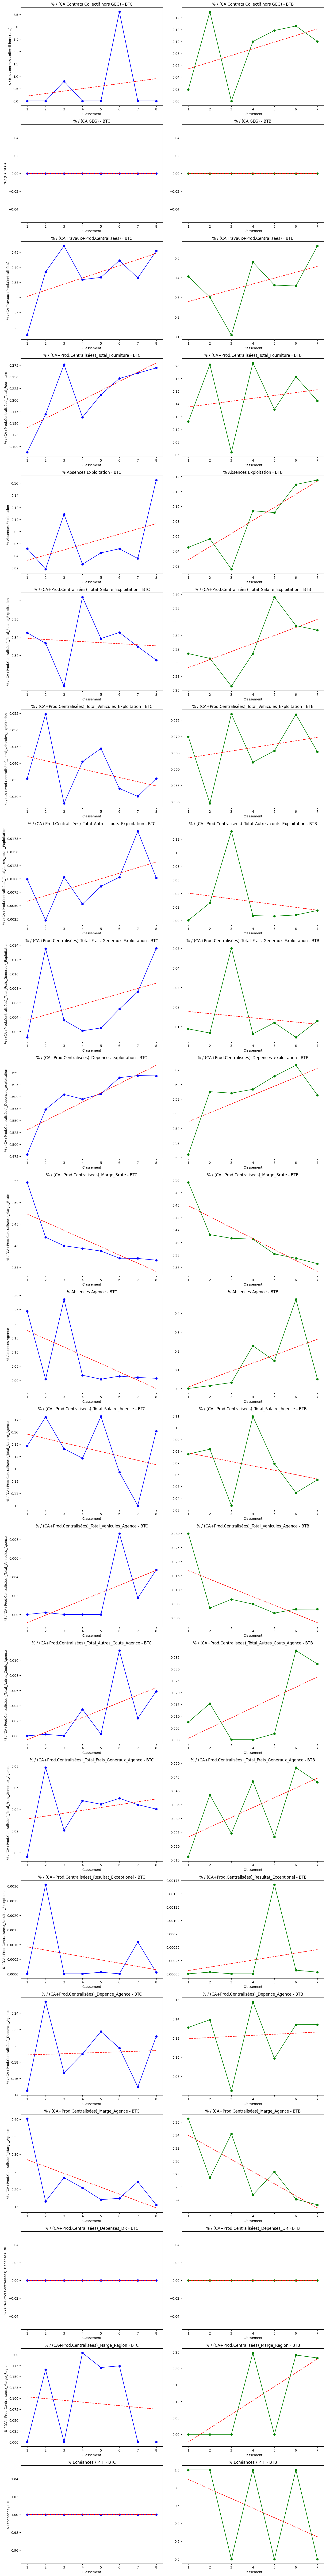

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Prepare data: Convert and clean
percent_columns = [col for col in ranked_agence_BTC.columns if '%' in str(col)]
for col in percent_columns:
    ranked_agence_BTC[col] = pd.to_numeric(ranked_agence_BTC[col], errors='coerce')
    ranked_agence_BTB[col] = pd.to_numeric(ranked_agence_BTB[col], errors='coerce')
    ranked_agence_BTC[col].fillna(0, inplace=True)
    ranked_agence_BTB[col].fillna(0, inplace=True)

# Create a single figure and multiple subplots
n_rows = len(percent_columns)  # One row per percentage column
fig, axs = plt.subplots(n_rows, 2, figsize=(14, 5 * n_rows))  # 2 columns for BTC and BTB
if n_rows == 1:
    axs = [axs]  # Ensure axs is always a 2D array even for one row

# Iterate over each percentage column to create plots
for i, col_name in enumerate(percent_columns):
    # Plot for BTC
    axs[i][0].plot(ranked_agence_BTC['classement'], ranked_agence_BTC[col_name], marker='o', color='blue')
    z_btc = np.polyfit(ranked_agence_BTC['classement'], ranked_agence_BTC[col_name], 1)
    p_btc = np.poly1d(z_btc)
    axs[i][0].plot(ranked_agence_BTC['classement'], p_btc(ranked_agence_BTC['classement']), "r--")
    axs[i][0].set_title(f"{col_name} - BTC")
    axs[i][0].set_xlabel('Classement')
    axs[i][0].set_ylabel(col_name)

    # Plot for BTB
    if col_name in ranked_agence_BTB.columns:
        axs[i][1].plot(ranked_agence_BTB['classement'], ranked_agence_BTB[col_name], marker='o', color='green')
        z_btb = np.polyfit(ranked_agence_BTB['classement'], ranked_agence_BTB[col_name], 1)
        p_btb = np.poly1d(z_btb)
        axs[i][1].plot(ranked_agence_BTB['classement'], p_btb(ranked_agence_BTB['classement']), "r--")
    axs[i][1].set_title(f"{col_name} - BTB")
    axs[i][1].set_xlabel('Classement')

# Adjust layout and show plots
plt.tight_layout()
plt.show()


In [25]:
[col for col in ranked_agence_BTC.columns if 'nombre' in str(col)]
print(ranked_agence_BTC.columns)

Index(['Filtre Agence', 'REGION', 'ACTIVITE', 'AGENCE', 'name_file',
       'name_sheet', 'Date', 'Type', 'CA Chauffage',
       'CA Robinetterie (Hors GEG)',
       ...
       'Amort', '2023.1', 'AC = 092901', 'Crédit bail', 'Amortissement OP',
       'Amortissement Agence', 'Amortissement Structure Commerciale',
       'Amortissement Structure DR', 'Taux MARGE BRUTE', 'classement'],
      dtype='object', length=393)


C:\Users\mrant\AppData\Local\Temp\ipykernel_352\3487921333.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agence_choisie["% Absences Exploitation"] = 0.1


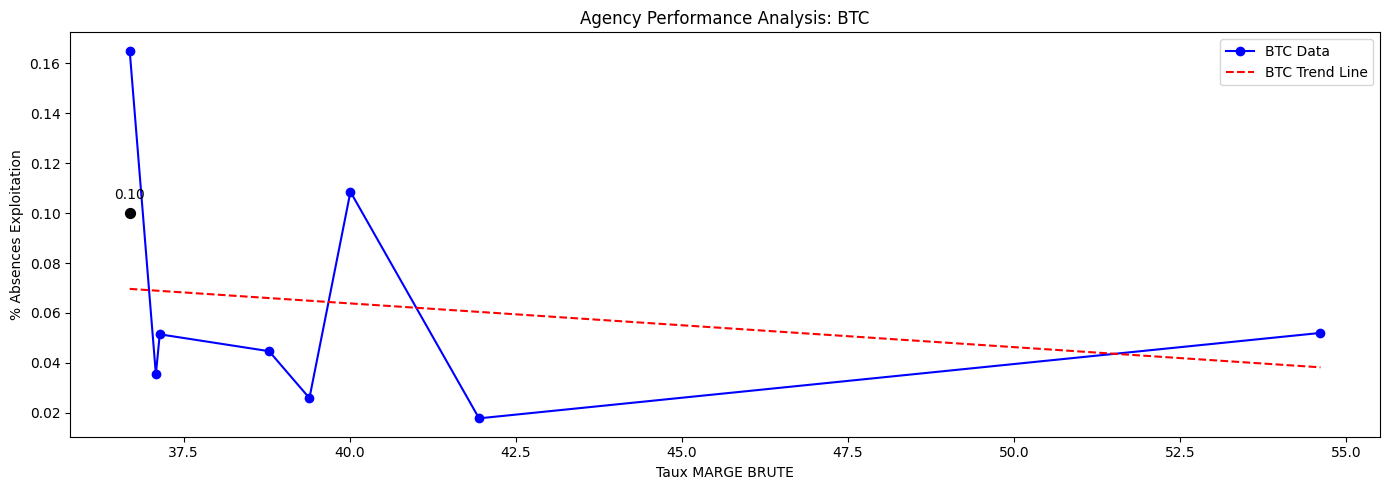

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'ranked_agence_BTC' and 'ranked_agence_BTB' are already defined and include necessary columns
agence_choisie = ranked_agence_BTC[ranked_agence_BTC["Filtre Agence"] == "6A-XTBRENT"]
agence_choisie["% Absences Exploitation"] = 0.1


# Setup figure and axes
fig, ax = plt.subplots(figsize=(14, 5))

axe_x = 'Taux MARGE BRUTE'
# axe_x = 'classement'
axe_y = '% Absences Exploitation'

# Check if the chosen agency has any data
if not agence_choisie.empty:
    activity_type = agence_choisie["ACTIVITE"].iloc[0]  # Get activity type from data

    if activity_type == "BTC":
        ax.plot(ranked_agence_BTC[axe_x], ranked_agence_BTC[axe_y], marker='o', color='blue', label='BTC Data')
        z_btc = np.polyfit(ranked_agence_BTC[axe_x].astype(float), ranked_agence_BTC[axe_y].astype(float), 1)  # Fit trend line for BTC
        p_btc = np.poly1d(z_btc)
        ax.plot(ranked_agence_BTC[axe_x], p_btc(ranked_agence_BTC[axe_x]), "r--", label='BTC Trend Line')
    elif activity_type == "BTB":
        ax.plot(ranked_agence_BTB[axe_x], ranked_agence_BTB[axe_y], marker='o', color='green', label='BTB Data')
        z_btb = np.polyfit(ranked_agence_BTB[axe_x].astype(float), ranked_agence_BTB[axe_y].astype(float), 1)  # Fit trend line for BTB
        p_btb = np.poly1d(z_btb)
        ax.plot(ranked_agence_BTB[axe_x], p_btb(ranked_agence_BTB[axe_x]), "r--", label='BTB Trend Line')

    # Annotate and highlight specific data points for the chosen agency
    for _, row in agence_choisie.iterrows():
        ax.scatter(row[axe_x], row[axe_y], color='black', s=50)  # Plot the point in black
        ax.annotate(f"{row[axe_y]:.2f}", (row[axe_x], row[axe_y]), textcoords="offset points", xytext=(0,10), ha='center', color='black')

    # Setting titles and labels
    ax.set_title(f"Agency Performance Analysis: {activity_type}")
    ax.set_xlabel(axe_x)
    ax.set_ylabel(axe_y)
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()
else:
    print("No data available for the specified agency.")


     Filtre Agence REGION ACTIVITE     AGENCE  \
2267    6A-XTSPERT  SOATL      BTC  Perpignan   

                                              name_file     name_sheet  \
2267  Data/Fiches\Reporting_SOATL 12_2023_Occitanie....  PERPIGNAN BTC   

           Date  Type  CA Chauffage  CA Robinetterie (Hors GEG)  ...  Amort  \
2267 2023-01-01  REEL         9.336                         0.0  ...    NaN   

      2023.1  AC = 092901  Crédit bail  Amortissement OP  \
2267     NaN          NaN          NaN               NaN   

      Amortissement Agence  Amortissement Structure Commerciale  \
2267                   NaN                                  NaN   

      Amortissement Structure DR  Taux MARGE BRUTE  classement  
2267                         NaN         40.012036         3.0  

[1 rows x 393 columns]


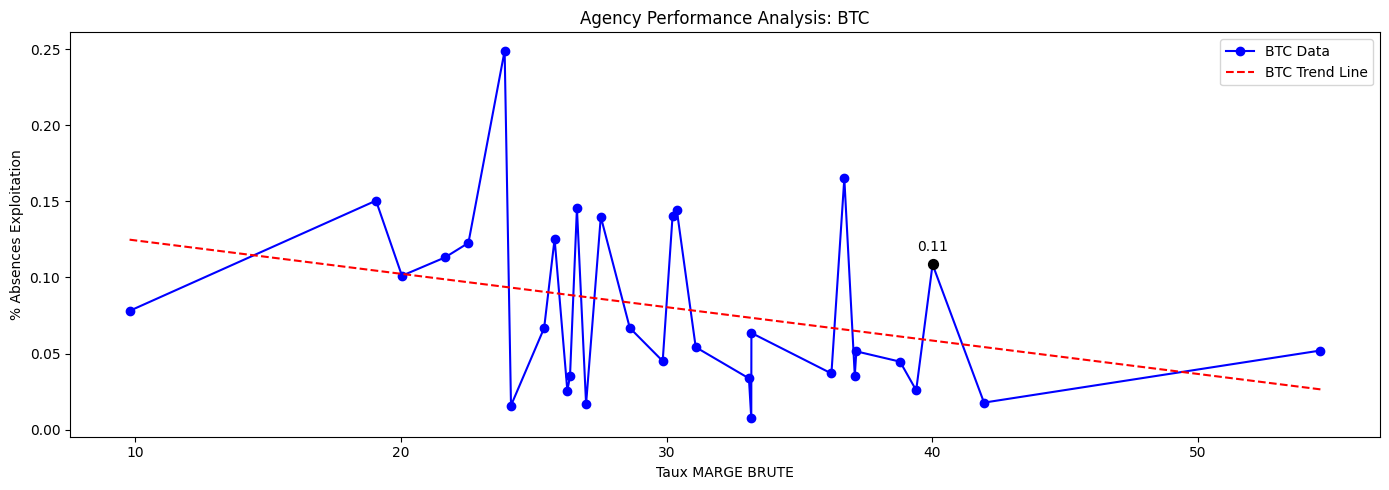

In [27]:
ranked_agence_BTC = df_year[(df_year["Date"]=="2023-01-01") & (df_year["ACTIVITE"]=="BTC")].sort_values(by="Taux MARGE BRUTE", ascending=True)
ranked_agence_BTB = df_year[(df_year["Date"]=="2023-01-01") & (df_year["ACTIVITE"]=="BTB")].sort_values(by="Taux MARGE BRUTE", ascending=True)

ranked_agence_BTC['classement'] = ranked_agence_BTC['Taux MARGE BRUTE'].rank(ascending=False, method='min')
ranked_agence_BTB['classement'] = ranked_agence_BTB['Taux MARGE BRUTE'].rank(ascending=False, method='min')

# rename_dict = {
#     '% / (CA+Prod.Centralisées)_1': '% / (CA+Prod.Centralisées)_Total_Fourniture',
#     '% / (CA+Prod.Centralisées)_2': '% / (CA+Prod.Centralisées)_Total_Salaire_Exploitation',
#     '% / (CA+Prod.Centralisées)_3': '% / (CA+Prod.Centralisées)_Total_Vehicules_Exploitation',
#     '% / (CA+Prod.Centralisées)_4': '% / (CA+Prod.Centralisées)_Total_Autres_couts_Exploitation',
#     '% / (CA+Prod.Centralisées)_5': '% / (CA+Prod.Centralisées)_Total_Frais_Generaux_Exploitation',
#     '% / (CA+Prod.Centralisées)_6': '% / (CA+Prod.Centralisées)_Depences_exploitation',
#     '% / (CA+Prod.Centralisées)_7': '% / (CA+Prod.Centralisées)_Marge_Brute',
#     '% / (CA+Prod.Centralisées)_8': '% / (CA+Prod.Centralisées)_Total_Salaire_Agence',
#     '% / (CA+Prod.Centralisées)_9': '% / (CA+Prod.Centralisées)_Total_Vehicules_Agence',
#     '% / (CA+Prod.Centralisées)_10': '% / (CA+Prod.Centralisées)_Total_Autres_Couts_Agence',
#     '% / (CA+Prod.Centralisées)_11': '% / (CA+Prod.Centralisées)_Total_Frais_Generaux_Agence',
#     '% / (CA+Prod.Centralisées)_12': '% / (CA+Prod.Centralisées)_Resultat_Exceptionel',
#     '% / (CA+Prod.Centralisées)_13': '% / (CA+Prod.Centralisées)_Depence_Agence',
#     '% / (CA+Prod.Centralisées)_14': '% / (CA+Prod.Centralisées)_Marge_Agence',
#     '% / (CA+Prod.Centralisées)_15': '% / (CA+Prod.Centralisées)_Depenses_DR',
#     '% / (CA+Prod.Centralisées)_16': '% / (CA+Prod.Centralisées)_Marge_Region',
#     '% Absences_1': '% Absences Exploitation',
#     '% Absences_2': '% Absences Agence',
# }

ranked_agence_BTC.rename(columns=rename_dict, inplace=True)
ranked_agence_BTB.rename(columns=rename_dict, inplace=True)
df_year.rename(columns=rename_dict, inplace=True)

# Assuming 'ranked_agence_BTC' and 'ranked_agence_BTB' are already defined and include necessary columns
#agence_choisie = df_year[(df_year["Date"]=="2023-01-01") & (df_year["Filtre Agence"]=="6A-TOUPERS")]

# Assuming 'ranked_agence_BTC' and 'ranked_agence_BTB' are already defined and include necessary columns
agence_choisie = ranked_agence_BTC[ranked_agence_BTC["Filtre Agence"] == "6A-XTSPERT"]
print(agence_choisie)

# Setup figure and axes
fig, ax = plt.subplots(figsize=(14, 5))

axe_x = 'Taux MARGE BRUTE'
# axe_x = 'classement'
axe_y = '% Absences Exploitation'

# Check if the chosen agency has any data
if not agence_choisie.empty:
    activity_type = agence_choisie["ACTIVITE"].iloc[0]  # Get activity type from data

    if activity_type == "BTC":
        ax.plot(ranked_agence_BTC[axe_x], ranked_agence_BTC[axe_y], marker='o', color='blue', label='BTC Data')
        z_btc = np.polyfit(ranked_agence_BTC[axe_x].astype(float), ranked_agence_BTC[axe_y].astype(float), 1)  # Fit trend line for BTC
        p_btc = np.poly1d(z_btc)
        ax.plot(ranked_agence_BTC[axe_x], p_btc(ranked_agence_BTC[axe_x]), "r--", label='BTC Trend Line')
    elif activity_type == "BTB":
        ax.plot(ranked_agence_BTB[axe_x], ranked_agence_BTB[axe_y], marker='o', color='green', label='BTB Data')
        z_btb = np.polyfit(ranked_agence_BTB[axe_x].astype(float), ranked_agence_BTB[axe_y].astype(float), 1)  # Fit trend line for BTB
        p_btb = np.poly1d(z_btb)
        ax.plot(ranked_agence_BTB[axe_x], p_btb(ranked_agence_BTB[axe_x]), "r--", label='BTB Trend Line')

    # Annotate and highlight specific data points for the chosen agency
    for _, row in agence_choisie.iterrows():
        ax.scatter(row[axe_x], row[axe_y], facecolor='black', edgecolors='black', s=50, zorder=5)  # Plot the point in black
        ax.annotate(f"{row[axe_y]:.2f}", (row[axe_x], row[axe_y]), textcoords="offset points", xytext=(0,10), ha='center', color='black')

    # Setting titles and labels
    ax.set_title(f"Agency Performance Analysis: {activity_type}")
    ax.set_xlabel(axe_x)
    ax.set_ylabel(axe_y)
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()
else:
    print("No data available for the specified agency.")

In [28]:
agence_choisie = ranked_agence_BTC[ranked_agence_BTC["Filtre Agence"] == "6A-XTSPERT"]
agence_choisie["name_sheet"].iloc[0]
ranked_agence_BTC[ranked_agence_BTC["name_sheet"] == 'PERPIGNAN BTC']

,Filtre Agence,REGION,ACTIVITE,AGENCE,name_file,name_sheet,Date,Type,CA Chauffage,CA Robinetterie (Hors GEG),...,Amort,2023.1,AC = 092901,Crédit bail,Amortissement OP,Amortissement Agence,Amortissement Structure Commerciale,Amortissement Structure DR,Taux MARGE BRUTE,classement
2267,6A-XTSPERT,SOATL,BTC,Perpignan,Data/Fiches\Reporting_SOATL 12_2023_Occitanie....,PERPIGNAN BTC,2023-01-01,REEL,9.336,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.012036,3.0


btb-btc:<br>
Nombre de Techniciens par Secrétaire <br>
CA par Techniciens (dont Intérim & S-T)<br>
Nombre de Tech. moyen par Magasinier<br>
Nombre de Tech. moyen par Chef Equipe<br>
% Absence
% Marge Brute<br>
"% / (CA+Prod.Centralisées)" pour les TOTAL FRAIS GENERAUX<br>

Fournitures Travaux & Ventes<br>


btb:<br>


btc:<br>
"Nombre de Contrats Individuels" ? à mettre en % avec le CA ou jsp quoi<br>



? jsp peut etre<br>
DEPENSES AGENCE<br>


Nbre chaudières sorties Adonix<br>

In [29]:
agencies = pd.concat([ranked_agence_BTB, ranked_agence_BTC])
# Dictionary to store the count of each unique value in the column
value_counts = {}

# Iterate over the unique values in the column
for value in agencies['AGENCE']:
    # Count the occurrences of the value in the column
    count = agencies[agencies['AGENCE'] == value].shape[0]
    # If the value occurs more than once
    if count > 1:
        # Retrieve the activity associated with the value
        activity = agencies[agencies['AGENCE'] == value]['ACTIVITE'].iloc[0] 
        # Append the activity to the value
        new_name = f"{value} ({activity})"
        # Update the dictionary with the new name and its count
        value_counts[new_name] = count
    else:
        # If the value occurs only once, use the original value and its count
        value_counts[value] = count

noms = sorted([str(noms) for noms in agencies["AGENCE"].unique()])
print(noms)

['Agen', 'Alençon ', 'Alsace', 'Angers', 'Anglet', 'Annecy', 'Arcachon', 'Artois', 'Avignon', 'Bonneuil', 'Bordeaux', 'Bourg', 'Bourges', 'Brest', 'Buc', 'Bézier', 'Béziers', 'Caen ', 'Cagnes', 'Carcassonne', 'Challans', 'Chambéry', 'Clermont', 'Compiègne', 'Depagaz', 'Dieppe ', 'Dijon', 'Dinan', 'Emerainville', 'Evreux ', 'Grenoble', 'Guyancourt', 'Hainaut-Cambrésis', 'La Roche Sur Yon', 'La Rochelle', 'Le Mans', 'Lille Collectif', 'Lille Individuel', 'Lorient', 'Lyon', 'Marseille', 'Metz', 'Montpellier', 'Nancy', 'Nantes', 'Nantes Gpl Exploitation', 'Nantes Gpl Gestion', 'Nîmes', 'Orléans', 'Paris ', 'Paris Montlouis', 'Pau', 'Perpignan', 'Plessis ', 'Poitiers', 'Portet', 'Portet Vernet', 'Quimper', 'Rennes', 'Rouen ', 'Saint-Etienne', 'Somme', 'Stains', 'Sète', 'Tarbes', 'Tours', 'Troyes', 'Valence', 'Var', 'Villefranche', 'Villepinte']


In [30]:
agencies.loc[agencies["AGENCE"] == "Perpignan"]

,Filtre Agence,REGION,ACTIVITE,AGENCE,name_file,name_sheet,Date,Type,CA Chauffage,CA Robinetterie (Hors GEG),...,Amort,2023.1,AC = 092901,Crédit bail,Amortissement OP,Amortissement Agence,Amortissement Structure Commerciale,Amortissement Structure DR,Taux MARGE BRUTE,classement
647,6A-TOUPERS,SOATL,BTB,Perpignan,Data/Fiches\Reporting_SOATL 12_2023_Occitanie....,PERPIGNAN BTB,2023-01-01,REEL,1383.141,675.966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.430173,13.0
2267,6A-XTSPERT,SOATL,BTC,Perpignan,Data/Fiches\Reporting_SOATL 12_2023_Occitanie....,PERPIGNAN BTC,2023-01-01,REEL,9.336,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.012036,3.0


In [31]:
print(agencies.shape)

(93, 393)


In [32]:
ranked_agence_BTB.loc[ranked_agence_BTB["AGENCE"] == "Perpignan"]
ranked_agence_BTC.loc[ranked_agence_BTC["AGENCE"] == "Perpignan"]

,Filtre Agence,REGION,ACTIVITE,AGENCE,name_file,name_sheet,Date,Type,CA Chauffage,CA Robinetterie (Hors GEG),...,Amort,2023.1,AC = 092901,Crédit bail,Amortissement OP,Amortissement Agence,Amortissement Structure Commerciale,Amortissement Structure DR,Taux MARGE BRUTE,classement
2267,6A-XTSPERT,SOATL,BTC,Perpignan,Data/Fiches\Reporting_SOATL 12_2023_Occitanie....,PERPIGNAN BTC,2023-01-01,REEL,9.336,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.012036,3.0


In [53]:
# Charger le fichier Excel
fichier_excel = pd.ExcelFile('Fiches/5_-_Fiches_Suiveuses_2023_11_IDF_Secteur_Robinetterie.xlsx')

# Lire la feuille spécifique du fichier Excel
nom_feuille = 'Stains'
donnees = pd.read_excel(fichier_excel, nom_feuille)

# Écrire les données dans un nouveau fichier Excel
nouveau_nom_fichier_excel = 'Fiches/test_import_fiche2.xlsx'
donnees.to_excel(nouveau_nom_fichier_excel, sheet_name='Stains', index=False)  # index=False pour exclure les index de ligne dans le fichier Excel

In [34]:
df = pd.read_excel('Fiches/final_df.xlsx')
df2 = pd.read_excel('Fiches/clean_df.xlsx')

# Obtenez les noms de colonnes de chaque DataFrame
columns_df1 = set(df.columns)
columns_df2 = set(df2.columns)

# Trouvez les colonnes manquantes dans df1 par rapport à df2
missing_columns_df1 = columns_df2 - columns_df1

# Trouvez les colonnes manquantes dans df2 par rapport à df1
missing_columns_df2 = columns_df1 - columns_df2

# Affichez les résultats
print("Colonnes manquantes dans df1 :", missing_columns_df1)
print("Colonnes manquantes dans df2 :", missing_columns_df2)

for column in df.columns:
    print(column)

Colonnes manquantes dans df1 : {'Publicité_2', 'Location Longue Duée', 'Frais bancaire', 'Reste à faire - BUDGET 2023', 'LLD_2', 'Conges payes non pris_2', 'Total CA Travaux Chaudières (Ag. + MCP)', 'Location Longue Durée_1', 'Période', 'Gains', 'Congrés, formation, stage', 'Reste à faire - BUDGET 2020', 'Téléphone_2', '% / (CA+Prod.Centralisées)_14', 'Stock Fournitures Techniques', 'DEPENSES AGENCE', 'CA Easy-Radiateur', 'Reste à faire - ACTU 2023', '0x17_3', 'Equivalent EFFECTIF Agence Intérim (ratio 38K€)', 'Prov. Congés payés CCMX (ex Prov CP CADR)_2', 'Nombre de Techniciens par Secrétaire', 'CA MCP-PAC Centralisé', 'Amortissement Agence', 'Location Immeubles_2', 'Voyages et déplacement_2', 'Véhicules Frais Admin_1', '0x17_1', 'Autres Coûts Véhicules (hors loc.CT)', '0x17_5', '2022', 'Amortissements', 'Reste à faire - ACTU 2020', 'Autres Cas', 'Location Longue Durée_2', 'CA Easy-Chaudière', 'name_file', 'Crédit-Bail Immobilier', 'Autres Coûts Véhicules (hors loc. CT)', '0.0', 'dont

C:\Users\mrant\AppData\Local\Temp\ipykernel_352\3713626969.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agence_choisie["% CA Contrat Collectif"] = agence_choisie["CA Contrats Collectif"]/agence_choisie["TOTAL CA + Prod Centralisées"]
C:\Users\mrant\AppData\Local\Temp\ipykernel_352\3713626969.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agence_choisie.drop(columns=["CA Contrats Collectif"], inplace=True)
C:\Users\mrant\AppData\Local\Temp\ipykernel_352\3713626969.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

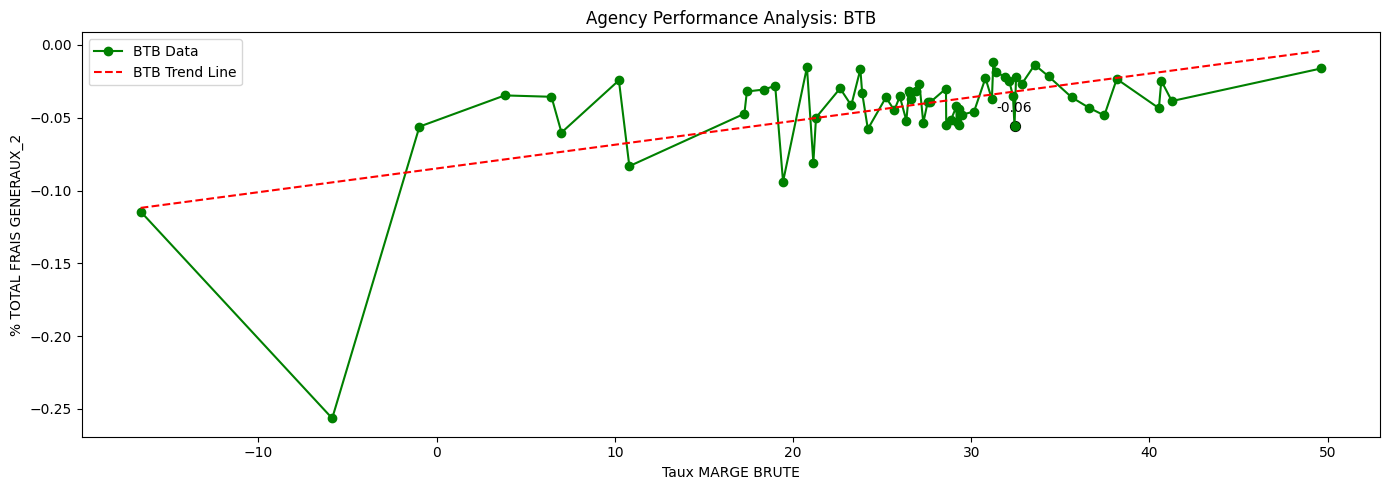

In [35]:
agence_choisie = df_year[(df_year["Date"]=="2023-01-01") & (df_year["Filtre Agence"]=="6A-TOUPERS")]

norm_btc = df_year[(df_year["Date"]=="2023-01-01") & (df_year["ACTIVITE"]=="BTC")].sort_values(by="Taux MARGE BRUTE", ascending=True)
norm_btb = df_year[(df_year["Date"]=="2023-01-01") & (df_year["ACTIVITE"]=="BTB")].sort_values(by="Taux MARGE BRUTE", ascending=True)

norm_btc['classement'] = norm_btc['Taux MARGE BRUTE'].rank(ascending=False, method='min')
norm_btb['classement'] = norm_btb['Taux MARGE BRUTE'].rank(ascending=False, method='min')

cols = ["CA Contrats Collectif","ETP EFFECTIF Exploitation (Présence)","Nbre de véhicules Exploitation",
        "TOTAL AUTRES COUTS_1","TOTAL FRAIS GENERAUX_1","ETP Chef Agence","ETP Responsable Exploitation","ETP Secrétaire/Assitant(e) Agence",
        "ETP EFFECTIF Agence (Présence)","TOTAL VEHICULES_2","TOTAL AUTRES COUTS_2","TOTAL FRAIS GENERAUX_2",
        "Nombre de Tech. moyen par Chef Equipe","Nombre de Tech. moyen par Magasinier","Nombre de Techniciens par Secrétaire", "Taux MARGE BRUTE"]

norm_btc["% CA Contrat Collectif"] = norm_btc["CA Contrats Collectif"]/norm_btc["TOTAL CA + Prod Centralisées"]
norm_btc.drop(columns=["CA Contrats Collectif"], inplace=True)
norm_btb["% CA Contrat Collectif"] = norm_btb["CA Contrats Collectif"]/norm_btb["TOTAL CA + Prod Centralisées"]
norm_btb.drop(columns=["CA Contrats Collectif"], inplace=True)
agence_choisie["% CA Contrat Collectif"] = agence_choisie["CA Contrats Collectif"]/agence_choisie["TOTAL CA + Prod Centralisées"]
agence_choisie.drop(columns=["CA Contrats Collectif"], inplace=True)

norm_btc["% ETP EFFECTIF Exploitation (Présence)"] = norm_btc["ETP EFFECTIF Exploitation (Présence)"]/norm_btc["TOTAL CA + Prod Centralisées"]
norm_btc.drop(columns=["ETP EFFECTIF Exploitation (Présence)"], inplace=True)
norm_btb["% ETP EFFECTIF Exploitation (Présence)"] = norm_btb["ETP EFFECTIF Exploitation (Présence)"]/norm_btb["TOTAL CA + Prod Centralisées"]
norm_btb.drop(columns=["ETP EFFECTIF Exploitation (Présence)"], inplace=True)
agence_choisie["% ETP EFFECTIF Exploitation (Présence)"] = agence_choisie["ETP EFFECTIF Exploitation (Présence)"]/agence_choisie["TOTAL CA + Prod Centralisées"]
agence_choisie.drop(columns=["ETP EFFECTIF Exploitation (Présence)"], inplace=True)

norm_btc["% Nbre de véhicules Exploitation"] = norm_btc["Nbre de véhicules Exploitation"]/norm_btc["TOTAL CA + Prod Centralisées"]
norm_btc.drop(columns=["Nbre de véhicules Exploitation"], inplace=True)
norm_btb["% Nbre de véhicules Exploitation"] = norm_btb["Nbre de véhicules Exploitation"]/norm_btb["TOTAL CA + Prod Centralisées"]
norm_btb.drop(columns=["Nbre de véhicules Exploitation"], inplace=True)
agence_choisie["% Nbre de véhicules Exploitation"] = agence_choisie["Nbre de véhicules Exploitation"]/agence_choisie["TOTAL CA + Prod Centralisées"]
agence_choisie.drop(columns=["Nbre de véhicules Exploitation"], inplace=True)

norm_btc["% TOTAL AUTRES COUTS_1"] = norm_btc["TOTAL AUTRES COUTS_1"]/norm_btc["TOTAL CA + Prod Centralisées"]
norm_btc.drop(columns=["TOTAL AUTRES COUTS_1"], inplace=True)
norm_btb["% TOTAL AUTRES COUTS_1"] = norm_btb["TOTAL AUTRES COUTS_1"]/norm_btb["TOTAL CA + Prod Centralisées"]
norm_btb.drop(columns=["TOTAL AUTRES COUTS_1"], inplace=True)
agence_choisie["% TOTAL AUTRES COUTS_1"] = agence_choisie["TOTAL AUTRES COUTS_1"]/agence_choisie["TOTAL CA + Prod Centralisées"]
agence_choisie.drop(columns=["TOTAL AUTRES COUTS_1"], inplace=True)

norm_btc["% TOTAL FRAIS GENERAUX_1"] = norm_btc["TOTAL FRAIS GENERAUX_1"]/norm_btc["TOTAL CA + Prod Centralisées"]
norm_btc.drop(columns=["TOTAL FRAIS GENERAUX_1"], inplace=True)
norm_btb["% TOTAL FRAIS GENERAUX_1"] = norm_btb["TOTAL FRAIS GENERAUX_1"]/norm_btb["TOTAL CA + Prod Centralisées"]
norm_btb.drop(columns=["TOTAL FRAIS GENERAUX_1"], inplace=True)
agence_choisie["% TOTAL FRAIS GENERAUX_1"] = agence_choisie["TOTAL FRAIS GENERAUX_1"]/agence_choisie["TOTAL CA + Prod Centralisées"]
agence_choisie.drop(columns=["TOTAL FRAIS GENERAUX_1"], inplace=True)

norm_btc["% ETP Chef Agence"] = norm_btc["ETP Chef Agence"]/norm_btc["TOTAL CA + Prod Centralisées"]
norm_btc.drop(columns=["ETP Chef Agence"], inplace=True)
norm_btb["% ETP Chef Agence"] = norm_btb["ETP Chef Agence"]/norm_btb["TOTAL CA + Prod Centralisées"]
norm_btb.drop(columns=["ETP Chef Agence"], inplace=True)
agence_choisie["% ETP Chef Agence"] = agence_choisie["ETP Chef Agence"]/agence_choisie["TOTAL CA + Prod Centralisées"]
agence_choisie.drop(columns=["ETP Chef Agence"], inplace=True)

norm_btc["% ETP Responsable Exploitation"] = norm_btc["ETP Responsable Exploitation"]/norm_btc["TOTAL CA + Prod Centralisées"]
norm_btc.drop(columns=["ETP Responsable Exploitation"], inplace=True)
norm_btb["% ETP Responsable Exploitation"] = norm_btb["ETP Responsable Exploitation"]/norm_btb["TOTAL CA + Prod Centralisées"]
norm_btb.drop(columns=["ETP Responsable Exploitation"], inplace=True)
agence_choisie["% ETP Responsable Exploitation"] = agence_choisie["ETP Responsable Exploitation"]/agence_choisie["TOTAL CA + Prod Centralisées"]
agence_choisie.drop(columns=["ETP Responsable Exploitation"], inplace=True)

norm_btc["% ETP Secrétaire/Assitant(e) Agence"] = norm_btc["ETP Secrétaire/Assitant(e) Agence"]/norm_btc["TOTAL CA + Prod Centralisées"]
norm_btc.drop(columns=["ETP Secrétaire/Assitant(e) Agence"], inplace=True)
norm_btb["% ETP Secrétaire/Assitant(e) Agence"] = norm_btb["ETP Secrétaire/Assitant(e) Agence"]/norm_btb["TOTAL CA + Prod Centralisées"]
norm_btb.drop(columns=["ETP Secrétaire/Assitant(e) Agence"], inplace=True)
agence_choisie["% ETP Secrétaire/Assitant(e) Agence"] = agence_choisie["ETP Secrétaire/Assitant(e) Agence"]/agence_choisie["TOTAL CA + Prod Centralisées"]
agence_choisie.drop(columns=["ETP Secrétaire/Assitant(e) Agence"], inplace=True)

norm_btc["% ETP EFFECTIF Agence (Présence)"] = norm_btc["ETP EFFECTIF Agence (Présence)"]/norm_btc["TOTAL CA + Prod Centralisées"]
norm_btc.drop(columns=["ETP EFFECTIF Agence (Présence)"], inplace=True)
norm_btb["% ETP EFFECTIF Agence (Présence)"] = norm_btb["ETP EFFECTIF Agence (Présence)"]/norm_btb["TOTAL CA + Prod Centralisées"]
norm_btb.drop(columns=["ETP EFFECTIF Agence (Présence)"], inplace=True)
agence_choisie["% ETP EFFECTIF Agence (Présence)"] = agence_choisie["ETP EFFECTIF Agence (Présence)"]/agence_choisie["TOTAL CA + Prod Centralisées"]
agence_choisie.drop(columns=["ETP EFFECTIF Agence (Présence)"], inplace=True)

norm_btc["% TOTAL VEHICULES_2"] = norm_btc["TOTAL VEHICULES_2"]/norm_btc["TOTAL CA + Prod Centralisées"]
norm_btc.drop(columns=["TOTAL VEHICULES_2"], inplace=True)
norm_btb["% TOTAL VEHICULES_2"] = norm_btb["TOTAL VEHICULES_2"]/norm_btb["TOTAL CA + Prod Centralisées"]
norm_btb.drop(columns=["TOTAL VEHICULES_2"], inplace=True)
agence_choisie["% TOTAL VEHICULES_2"] = agence_choisie["TOTAL VEHICULES_2"]/agence_choisie["TOTAL CA + Prod Centralisées"]
agence_choisie.drop(columns=["TOTAL VEHICULES_2"], inplace=True)


norm_btc["% TOTAL AUTRES COUTS_2"] = norm_btc["TOTAL AUTRES COUTS_2"]/norm_btc["TOTAL CA + Prod Centralisées"]
norm_btc.drop(columns=["TOTAL AUTRES COUTS_2"], inplace=True)
norm_btb["% TOTAL AUTRES COUTS_2"] = norm_btb["TOTAL AUTRES COUTS_2"]/norm_btb["TOTAL CA + Prod Centralisées"]
norm_btb.drop(columns=["TOTAL AUTRES COUTS_2"], inplace=True)
agence_choisie["% TOTAL AUTRES COUTS_2"] = agence_choisie["TOTAL AUTRES COUTS_2"]/agence_choisie["TOTAL CA + Prod Centralisées"]
agence_choisie.drop(columns=["TOTAL AUTRES COUTS_2"], inplace=True)

norm_btc["% TOTAL FRAIS GENERAUX_2"] = norm_btc["TOTAL FRAIS GENERAUX_2"]/norm_btc["TOTAL CA + Prod Centralisées"]
norm_btc.drop(columns=["TOTAL FRAIS GENERAUX_2"], inplace=True)
norm_btb["% TOTAL FRAIS GENERAUX_2"] = norm_btb["TOTAL FRAIS GENERAUX_2"]/norm_btb["TOTAL CA + Prod Centralisées"]
norm_btb.drop(columns=["TOTAL FRAIS GENERAUX_2"], inplace=True)
agence_choisie["% TOTAL FRAIS GENERAUX_2"] = agence_choisie["TOTAL FRAIS GENERAUX_2"]/agence_choisie["TOTAL CA + Prod Centralisées"]
agence_choisie.drop(columns=["TOTAL FRAIS GENERAUX_2"], inplace=True)

norm_btc.drop(columns="TOTAL CA + Prod Centralisées", inplace=True)
norm_btb.drop(columns="TOTAL CA + Prod Centralisées", inplace=True)
agence_choisie.drop(columns="TOTAL CA + Prod Centralisées", inplace=True)

norm_btc.rename(columns=rename_dict, inplace=True)
norm_btb.rename(columns=rename_dict, inplace=True)
agence_choisie.rename(columns=rename_dict, inplace=True)

col_bien = ["% / (CA+Prod.Centralisées)_Marge_Agence", "% / (CA+Prod.Centralisées)_Marge_Brute", "% / (CA+Prod.Centralisées)_Depences_exploitation",
            "% / (CA+Prod.Centralisées)_Total_Salaire_Exploitation", "% Absences Exploitation", '% / (CA+Prod.Centralisées)_Total_Fourniture',
            "% TOTAL FRAIS GENERAUX_1", "% TOTAL FRAIS GENERAUX_2"]

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



norm_btc.rename(columns=rename_dict, inplace=True)
ranked_agence_BTB.rename(columns=rename_dict, inplace=True)
df_year.rename(columns=rename_dict, inplace=True)

# Assuming 'norm_btc' and 'ranked_agence_BTB' are already defined and include necessary columns


# Setup figure and axes
fig, ax = plt.subplots(figsize=(14, 5))

axe_x = 'Taux MARGE BRUTE'
# axe_x = 'classement'
axe_y = '% TOTAL FRAIS GENERAUX_2'

# Check if the chosen agency has any data
if not agence_choisie.empty:
    activity_type = agence_choisie["ACTIVITE"].iloc[0]  # Get activity type from data

    if activity_type == "BTC":
        ax.plot(norm_btc[axe_x], norm_btc[axe_y], marker='o', color='blue', label='BTC Data')
        z_btc = np.polyfit(norm_btc[axe_x].astype(float), norm_btc[axe_y].astype(float), 1)  # Fit trend line for BTC
        p_btc = np.poly1d(z_btc)
        ax.plot(norm_btc[axe_x], p_btc(norm_btc[axe_x]), "r--", label='BTC Trend Line')
    elif activity_type == "BTB":
        ax.plot(norm_btb[axe_x], norm_btb[axe_y], marker='o', color='green', label='BTB Data')
        z_btb = np.polyfit(norm_btb[axe_x].astype(float), norm_btb[axe_y].astype(float), 1)  # Fit trend line for BTB
        p_btb = np.poly1d(z_btb)
        ax.plot(norm_btb[axe_x], p_btb(norm_btb[axe_x]), "r--", label='BTB Trend Line')

    # Annotate and highlight specific data points for the chosen agency
    for _, row in agence_choisie.iterrows():
        ax.scatter(row[axe_x], row[axe_y], color='black', s=50)  # Plot the point in black
        ax.annotate(f"{row[axe_y]:.2f}", (row[axe_x], row[axe_y]), textcoords="offset points", xytext=(0,10), ha='center', color='black')

    # Setting titles and labels
    ax.set_title(f"Agency Performance Analysis: {activity_type}")
    ax.set_xlabel(axe_x)
    ax.set_ylabel(axe_y)
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()
else:
    print("No data available for the specified agency.")

# save norm_btc and norm_btb to excel
norm_btc.to_excel("Fiches/norm_btc.xlsx", index=False)
norm_btb.to_excel("Fiches/norm_btb.xlsx", index=False)


In [36]:
df_final = pd.read_excel("Fiches/final_df.xlsx")
print(df_final.columns)
print(df_final.shape)
df_final["Date"]=="2023-01-01"

Index(['Filtre Agence', 'Date', 'Type', 'ACTIVITE', 'CA Chauffage',
       'CA Robinetterie (Hors GEG)', 'CA Gérance d'Eau', 'CA Multi',
       'CA Comptage', 'CA Contrats Collectif',
       ...
       'Fournitures Hygiène Sécurité_2', 'Refacturations Autres Coûts_2',
       'TOTAL AUTRES COUTS_2', '% / (CA+Prod.Centralisées)_10',
       'Eau, gaz, electricite_2', 'Fournitures de Bureau_2', 'Frais Postaux_2',
       'Location Info Bureau', 'AGENCE', 'REGION'],
      dtype='object', length=236)
(17, 236)


0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
Name: Date, dtype: bool

In [64]:
norm_btc = pd.read_excel("Fiches/norm_btc.xlsx")
norm_btb = pd.read_excel("Fiches/norm_btb.xlsx")
agencies = pd.concat([norm_btc, norm_btb])

from import_data import import_fiche, import_ref, select_agences

df = import_fiche('Fiches/test_import_fiche.xlsx')
glob_df = import_ref("Fiches/Benchmark Classement Agences REEL 2022 et REEL 2023.xlsx")
df = select_agences(df, glob_df)

tmp = pd.DataFrame()
tmp["Taux MARGE BRUTE"] = 100 * df["MARGE BRUTE"]/df["TOTAL CA + Prod Centralisées"]
df = pd.concat([df, tmp], axis=1)
df = df[(df["Taux MARGE BRUTE"] < 100) & (df["Taux MARGE BRUTE"] > -100)]

# ValueError: invalid literal for int() with base 10: '2021.12' resolve

df_year = df[(df['Date'].astype(str).str.split('.').str[-1] == '12') & (df['Type'] =="REEL")]
df_year = df_year[(df_year['Date']!= '12')]
# Supprimer les doublons de date pour chaque agence
df_year = df_year.drop_duplicates(subset=["Filtre Agence", "Date"])
df_year["Date"] = pd.to_datetime(df_year["Date"], format='%Y.%m')
print(df_year.shape)
print(df_year.iloc[2])
df_year2 = pd.read_excel("Fiches/df_year.xlsx")
print(df_year2.shape)
df1 = df_year
df2 = df_year2

# Obtenez les noms de colonnes de chaque DataFrame
columns_df1 = set(df1.columns)
columns_df2 = set(df2.columns)

# Trouvez les colonnes manquantes dans df1 par rapport à df2
missing_columns_df1 = columns_df2 - columns_df1

# Trouvez les colonnes manquantes dans df2 par rapport à df1
missing_columns_df2 = columns_df1 - columns_df2

# Affichez les résultats
print("Colonnes manquantes dans df1 :", missing_columns_df1)
print("Colonnes manquantes dans df2 :", missing_columns_df2)

for column in df.columns:
    print(column)

(3, 238)
name_sheet                         BONNEUIL
Filtre Agence                   2A-RPU-BONS
Date                    2023-12-01 00:00:00
Type                                   REEL
CA Chauffage                          4.252
                               ...         
Location Info Bureau                 -9.775
AGENCE                             Bonneuil
REGION                              IDF-NDI
ACTIVITE                                BTB
Taux MARGE BRUTE                  38.167283
Name: 16, Length: 238, dtype: object
(535, 392)
Colonnes manquantes dans df1 : {'Publicité_2', 'Location Longue Duée', 'Frais bancaire', 'Reste à faire - BUDGET 2023', 'LLD_2', 'Conges payes non pris_2', 'Total CA Travaux Chaudières (Ag. + MCP)', 'Location Longue Durée_1', 'Période', 'Gains', 'Congrés, formation, stage', 'Reste à faire - BUDGET 2020', 'Téléphone_2', '% / (CA+Prod.Centralisées)_14', 'Stock Fournitures Techniques', 'DEPENSES AGENCE', 'CA Easy-Radiateur', 'Reste à faire - ACTU 2023', '0x1

In [38]:
# Comparer les colonnes de df1 et df2 pour trouver les colonnes manquantes dans df1
colonnes_manquantes = df2.columns.difference(df1.columns)

# Ajouter les colonnes manquantes à df1
df1 = df1.assign(**{colonne: 0 for colonne in colonnes_manquantes})
#df1.drop(columns=[set()], inplace=True)  

# Obtenez les noms de colonnes de chaque DataFrame
columns_df1 = set(df1.columns)
columns_df2 = set(df2.columns)

# Trouvez les colonnes manquantes dans df1 par rapport à df2
missing_columns_df1 = columns_df2 - columns_df1

# Trouvez les colonnes manquantes dans df2 par rapport à df1
missing_columns_df2 = columns_df1 - columns_df2

# Affichez les résultats
print("Colonnes manquantes dans df1 :", missing_columns_df1)
print("Colonnes manquantes dans df2 :", missing_columns_df2)

for column in df.columns:
    print(column)

Colonnes manquantes dans df1 : set()
Colonnes manquantes dans df2 : set()
name_sheet
Filtre Agence
Date
Type
CA Chauffage
CA Robinetterie (Hors GEG)
CA Gérance d'Eau
CA Multi
CA Comptage
CA Contrats Collectif
CA Contrats Individuel
TOTAL CA CONTRATS
Travaux Collectif
Tvx Individuel: Dépannages Sous Contrat
Tvx Individuel: Dépannages Hors Contrat
Total CA Travaux Chaudières (Ag. + Easy)
Tvx Individuel: Chaudières Agence
Tvx Individuel: Travaux Radiateurs
Tvx Individuel: Autres Chauffage
Tvx Individuel: Travaux Plomberie
Tvx Individuel: Travaux ECS Electriques
Tvx Individuel: Travaux PAC
Tvx Individuel: Travaux DAAF
Tvx Individuel: Autres Métiers
Tvx Ind. Activités Traditionnelles
Easy-Ballon Centralisée
Easy-Ballon Agence
CA MCP-Ballon
CA MCP-Chaudière Centralisée
CA MCP-Chaudière Agence
CA MCP-Chaudière
CA MCP-Radiateur Centralisée
CA MCP-Radiateur Agence
CA MCP-Radiateur
CA  MCP-PAC Centralisée
CA  MCP-PAC Agence
CA MCP-PAC
CA Nest Centralisée
CA Nest Agence
CA Nest
CA Bornes Partenar

C:\Users\mrant\AppData\Local\Temp\ipykernel_352\596220884.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1 = df1.assign(**{colonne: 0 for colonne in colonnes_manquantes})
C:\Users\mrant\AppData\Local\Temp\ipykernel_352\596220884.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1 = df1.assign(**{colonne: 0 for colonne in colonnes_manquantes})
C:\Users\mrant\AppData\Local\Temp\ipykernel_352\596220884.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many tim

In [55]:
from import_data import import_fiche, import_ref, select_agences
df = import_fiche('Fiches/1_-_Fiches_Suiveuses_2023_12_Region_IDF_Maintenance_-_Normandie.xlsx')
glob_df = import_ref("Fiches/Benchmark Classement Agences REEL 2022 et REEL 2023.xlsx")
final_df = select_agences(df, glob_df)


In [56]:
[col for col in final_df.columns if 'GENERAUX' in str(col)]

['TOTAL FRAIS GENERAUX_1']

In [57]:
tmp = pd.DataFrame()
tmp["Taux MARGE BRUTE"] = 100 * final_df["MARGE BRUTE"]/final_df["TOTAL CA + Prod Centralisées"]
final_df = pd.concat([final_df, tmp], axis=1)
final_df = final_df[(final_df["Taux MARGE BRUTE"] < 100) & (final_df["Taux MARGE BRUTE"] > -100)]
print(final_df.shape)

(17, 238)


In [58]:
final_df["Date"] = final_df["Date"].astype(float)
df_year = final_df[(final_df['Date'] > 100) & (final_df['Type'] =="REEL")]

# Supprimer les doublons de date pour chaque agence
df_year = df_year.drop_duplicates(subset=["Filtre Agence", "Date"])
df_year["Date"] = pd.to_datetime(df_year["Date"], format='%Y')
print(df_year)

   name_sheet Filtre Agence       Date  Type  CA Chauffage  \
0    BONNEUIL   2A-RPU-BONS 2021-01-01  REEL         3.539   
1    BONNEUIL   2A-RPU-BONS 2022-01-01  REEL         6.632   
16   BONNEUIL   2A-RPU-BONS 2023-01-01  REEL         4.252   

    CA Robinetterie (Hors GEG)  CA Gérance d'Eau  CA Multi  CA Comptage  \
0                     2669.274                 0  3340.026            0   
1                     2321.700                 0  4169.428            0   
16                    1719.962                 0  4173.642            0   

    CA Contrats Collectif  ...  TOTAL AUTRES COUTS_2  \
0                6012.839  ...               -27.879   
1                6497.760  ...               -26.624   
16               5897.856  ...               -16.021   

    % / (CA+Prod.Centralisées)_10  Eau, gaz, electricite_2  \
0                        0.004124                  -13.940   
1                        0.003851                  -16.253   
16                       0.002573      

C:\Users\mrant\AppData\Local\Temp\ipykernel_352\1570851596.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agence_choisie["% CA Contrat Collectif"] = agence_choisie["CA Contrats Collectif"]/agence_choisie["TOTAL CA + Prod Centralisées"]
C:\Users\mrant\AppData\Local\Temp\ipykernel_352\1570851596.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agence_choisie.drop(columns=["CA Contrats Collectif"], inplace=True)
C:\Users\mrant\AppData\Local\Temp\ipykernel_352\1570851596.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

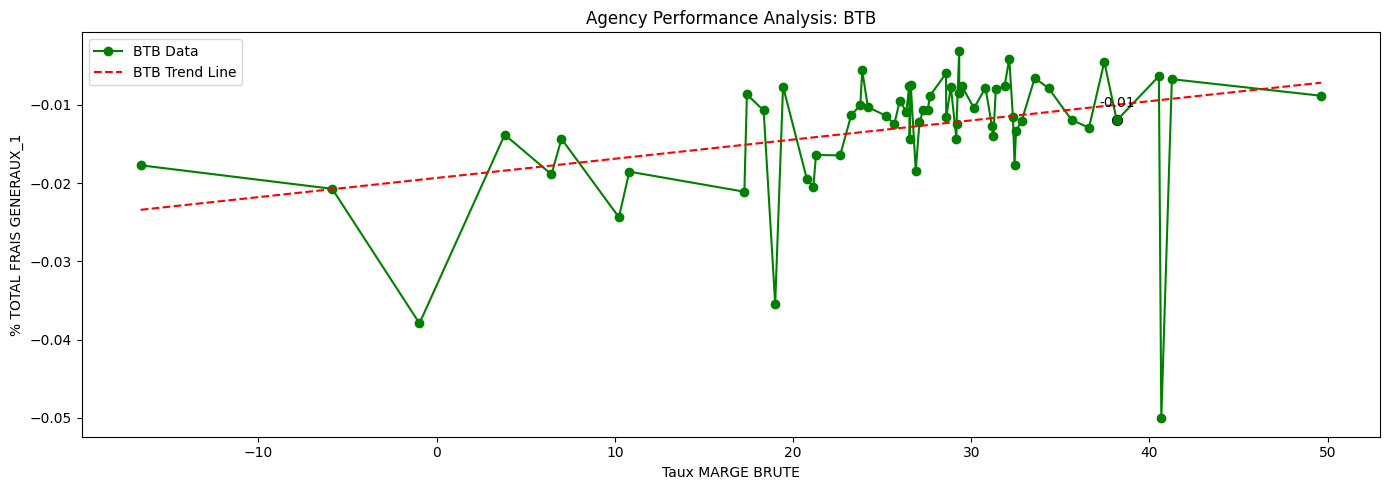

In [61]:

agence_choisie = df_year[(df_year["Date"]=="2023-01-01")]

agence_choisie["% CA Contrat Collectif"] = agence_choisie["CA Contrats Collectif"]/agence_choisie["TOTAL CA + Prod Centralisées"]
agence_choisie.drop(columns=["CA Contrats Collectif"], inplace=True)

agence_choisie["% ETP EFFECTIF Exploitation (Présence)"] = agence_choisie["ETP EFFECTIF Exploitation (Présence)"]/agence_choisie["TOTAL CA + Prod Centralisées"]
agence_choisie.drop(columns=["ETP EFFECTIF Exploitation (Présence)"], inplace=True)

agence_choisie["% Nbre de véhicules Exploitation"] = agence_choisie["Nbre de véhicules Exploitation"]/agence_choisie["TOTAL CA + Prod Centralisées"]
agence_choisie.drop(columns=["Nbre de véhicules Exploitation"], inplace=True)

agence_choisie["% TOTAL AUTRES COUTS_1"] = agence_choisie["TOTAL AUTRES COUTS_1"]/agence_choisie["TOTAL CA + Prod Centralisées"]
agence_choisie.drop(columns=["TOTAL AUTRES COUTS_1"], inplace=True)

agence_choisie["% TOTAL FRAIS GENERAUX_1"] = agence_choisie["TOTAL FRAIS GENERAUX_1"]/agence_choisie["TOTAL CA + Prod Centralisées"]
agence_choisie.drop(columns=["TOTAL FRAIS GENERAUX_1"], inplace=True)

# agence_choisie["% TOTAL FRAIS GENERAUX_2"] = agence_choisie["TOTAL FRAIS GENERAUX_2"]/agence_choisie["TOTAL CA + Prod Centralisées"]
# agence_choisie.drop(columns=["TOTAL FRAIS GENERAUX_2"], inplace=True)

agence_choisie["% ETP Chef Agence"] = agence_choisie["ETP Chef Agence"]/agence_choisie["TOTAL CA + Prod Centralisées"]
agence_choisie.drop(columns=["ETP Chef Agence"], inplace=True)

agence_choisie["% ETP Responsable Exploitation"] = agence_choisie["ETP Responsable Exploitation"]/agence_choisie["TOTAL CA + Prod Centralisées"]
agence_choisie.drop(columns=["ETP Responsable Exploitation"], inplace=True)

agence_choisie["% ETP Secrétaire/Assitant(e) Agence"] = agence_choisie["ETP Secrétaire/Assitant(e) Agence"]/agence_choisie["TOTAL CA + Prod Centralisées"]
agence_choisie.drop(columns=["ETP Secrétaire/Assitant(e) Agence"], inplace=True)

agence_choisie["% ETP EFFECTIF Agence (Présence)"] = agence_choisie["ETP EFFECTIF Agence (Présence)"]/agence_choisie["TOTAL CA + Prod Centralisées"]
agence_choisie.drop(columns=["ETP EFFECTIF Agence (Présence)"], inplace=True)

agence_choisie["% TOTAL VEHICULES_2"] = agence_choisie["TOTAL VEHICULES_2"]/agence_choisie["TOTAL CA + Prod Centralisées"]
agence_choisie.drop(columns=["TOTAL VEHICULES_2"], inplace=True)

agence_choisie["% TOTAL AUTRES COUTS_2"] = agence_choisie["TOTAL AUTRES COUTS_2"]/agence_choisie["TOTAL CA + Prod Centralisées"]
agence_choisie.drop(columns=["TOTAL AUTRES COUTS_2"], inplace=True)

#agence_choisie["% TOTAL FRAIS GENERAUX_2"] = agence_choisie["TOTAL FRAIS GENERAUX_2"]/agence_choisie["TOTAL CA + Prod Centralisées"]
#agence_choisie.drop(columns=["TOTAL FRAIS GENERAUX_2"], inplace=True)

agence_choisie.drop(columns="TOTAL CA + Prod Centralisées", inplace=True)

rename_dict = {
            '% / (CA+Prod.Centralisées)_1': '% / (CA+Prod.Centralisées)_Total_Fourniture',
            '% / (CA+Prod.Centralisées)_2': '% / (CA+Prod.Centralisées)_Total_Salaire_Exploitation',
            '% / (CA+Prod.Centralisées)_3': '% / (CA+Prod.Centralisées)_Total_Vehicules_Exploitation',
            '% / (CA+Prod.Centralisées)_4': '% / (CA+Prod.Centralisées)_Total_Autres_couts_Exploitation',
            '% / (CA+Prod.Centralisées)_5': '% / (CA+Prod.Centralisées)_Total_Frais_Generaux_Exploitation',
            '% / (CA+Prod.Centralisées)_6': '% / (CA+Prod.Centralisées)_Depences_exploitation',
            '% / (CA+Prod.Centralisées)_7': '% / (CA+Prod.Centralisées)_Marge_Brute',
            '% / (CA+Prod.Centralisées)_8': '% / (CA+Prod.Centralisées)_Total_Salaire_Agence',
            '% / (CA+Prod.Centralisées)_9': '% / (CA+Prod.Centralisées)_Total_Vehicules_Agence',
            '% / (CA+Prod.Centralisées)_10': '% / (CA+Prod.Centralisées)_Total_Autres_Couts_Agence',
            '% / (CA+Prod.Centralisées)_11': '% / (CA+Prod.Centralisées)_Total_Frais_Generaux_Agence',
            '% / (CA+Prod.Centralisées)_12': '% / (CA+Prod.Centralisées)_Resultat_Exceptionel',
            '% / (CA+Prod.Centralisées)_13': '% / (CA+Prod.Centralisées)_Depence_Agence',
            '% / (CA+Prod.Centralisées)_14': '% / (CA+Prod.Centralisées)_Marge_Agence',
            '% / (CA+Prod.Centralisées)_15': '% / (CA+Prod.Centralisées)_Depenses_DR',
            '% / (CA+Prod.Centralisées)_16': '% / (CA+Prod.Centralisées)_Marge_Region',
            '% Absences_1': '% Absences Exploitation',
            '% Absences_2': '% Absences Agence',
        }

agence_choisie.rename(columns=rename_dict, inplace=True)


#col_bien = ["% / (CA+Prod.Centralisées)_Marge_Agence", "% / (CA+Prod.Centralisées)_Marge_Brute", "% / (CA+Prod.Centralisées)_Depences_exploitation","% / (CA+Prod.Centralisées)_Total_Salaire_Exploitation", "% Absences Exploitation", '% / (CA+Prod.Centralisées)_Total_Fourniture',"% TOTAL FRAIS GENERAUX_1", "% TOTAL FRAIS GENERAUX_2"]

# Setup figure and axes
fig, ax = plt.subplots(figsize=(14, 5))

axe_x = 'Taux MARGE BRUTE'
# axe_x = 'classement'
axe_y = '% TOTAL FRAIS GENERAUX_1'

# Check if the chosen agency has any data
if not agence_choisie.empty:
    activity_type = agence_choisie["ACTIVITE"].iloc[0]  # Get activity type from data

    if activity_type == "BTC":
        ax.plot(norm_btc[axe_x], norm_btc[axe_y], marker='o', color='blue', label='BTC Data')
        z_btc = np.polyfit(norm_btc[axe_x].astype(float), norm_btc[axe_y].astype(float), 1)  # Fit trend line for BTC
        p_btc = np.poly1d(z_btc)
        ax.plot(norm_btc[axe_x], p_btc(norm_btc[axe_x]), "r--", label='BTC Trend Line')
    elif activity_type == "BTB":
        ax.plot(norm_btb[axe_x], norm_btb[axe_y], marker='o', color='green', label='BTB Data')
        z_btb = np.polyfit(norm_btb[axe_x].astype(float), norm_btb[axe_y].astype(float), 1)  # Fit trend line for BTB
        p_btb = np.poly1d(z_btb)
        ax.plot(norm_btb[axe_x], p_btb(norm_btb[axe_x]), "r--", label='BTB Trend Line')

    # Annotate and highlight specific data points for the chosen agency
    for _, row in agence_choisie.iterrows():
        ax.scatter(row[axe_x], row[axe_y], color='black', s=50)  # Plot the point in black
        ax.annotate(f"{row[axe_y]:.2f}", (row[axe_x], row[axe_y]), textcoords="offset points", xytext=(0,10), ha='center', color='black')

    # Setting titles and labels
    ax.set_title(f"Agency Performance Analysis: {activity_type}")
    ax.set_xlabel(axe_x)
    ax.set_ylabel(axe_y)
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()
else:
    print("No data available for the specified agency.")

In [ ]:
agence_choisie
agence_choisie['name_sheet']

16     BONNEUIL
33       STAINS
50          BUC
67    MONTLOUIS
Name: name_sheet, dtype: object

In [63]:
[col for col in agence_choisie.columns if 'GENERAUX' in str(col)]

['% TOTAL FRAIS GENERAUX_1']